In [1]:
import pandas as pd
import numpy as np
from equity_plot import equity_plot
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import compress
from scipy import stats
# import qgrid
import yfinance as yf
import datetime as dt
import time
from progressbar import *
from ipywidgets import interact
import random
import pandas_market_calendars as mcal
import bisect 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
# plt.rcParams['font.sans-serif'] = ['SimHei']
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 30

Data

In [16]:
stock_price = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_調整後股價資料\收盤價(元).csv")
stock_lend = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券\融券(買+賣)除以成交量 %.csv")
stock_lend_1 = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券\融資維持率.csv")
stock_market = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_借券餘額\市場別.csv")
stock_volume = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_調整後股價資料\成交值(千元).csv")
industry = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\industry.csv")

Time

In [17]:
bt_start = "2012-01-01"
bt_end = "2021-10-01"

Data

In [18]:
stock_df = stock_price.copy()
stock_df['年月日'] = pd.to_datetime(stock_df['年月日'].astype('str'))
stock_df = stock_df.set_index('年月日').dropna(axis = 1)
stock_df = stock_df.loc[bt_start:bt_end]

market_df = stock_market.copy()
market_df['年月日'] = pd.to_datetime(market_df['年月日'].astype('str'))
market_df = market_df.set_index('年月日')
market_df = market_df.loc[bt_start:bt_end].dropna(axis = 1)

volume_df = stock_volume.copy()
volume_df['年月日'] = pd.to_datetime(volume_df['年月日'].astype('str'))
volume_df = volume_df.set_index('年月日').dropna(axis = 1)
volume_df = volume_df.loc[bt_start:bt_end]

industry['公司簡稱'] = industry['公司簡稱'].astype(str)
industry_df = industry.copy()

In [62]:
def df_preprocess(factor_df,stock_df,market_df) : 
    
    df = factor_df.copy()
    df['年月日'] = pd.to_datetime(df['年月日'].astype('str'))
    df = df.set_index('年月日').dropna(axis = 1)
    df = df.loc[bt_start:bt_end].replace(['           -','      -','     -','              -','        -'],np.nan).dropna(axis = 1).astype('float')

    stock_set = set(stock_df.columns) & set(df.columns)&set(market_df.tail(1)[market_df.tail(1) == 'TSE  '].dropna(axis = 1).columns)
    stock_df = stock_df[list(stock_set)]
    df = df[list(stock_set)]
    stock_close = stock_df.copy()
    
    return df , stock_close, stock_set

In [63]:
lend_df , stock_close ,stock_set= df_preprocess(stock_lend_1,stock_df,market_df)

Signal

In [26]:
signal_df = lend_df

In [44]:
signal_df

2347    6189    9941    4906    2538    1477    1806    5007  \
年月日                                                                          
2012-01-02  170.54  154.42  152.06  122.58  134.06  166.64  117.08  150.66   
2012-01-03  171.37  153.58  158.15  125.22  136.77  167.35  117.47  150.30   
2012-01-04  172.05  153.61  156.70  127.08  134.97  169.02  117.73  151.42   
2012-01-05  172.65  153.65  156.50  127.16  134.74  169.90  119.60  149.60   
2012-01-06  173.07  153.66  158.05  132.86  134.90  170.10  118.44  149.68   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-09-27  167.33  161.64  167.76  141.42  171.07  166.13  159.69  167.36   
2021-09-28  166.07  161.85  168.25  141.05  174.36  165.45  157.11  167.07   
2021-09-29  163.93  160.64  164.73  142.64  177.53  163.80  153.82  165.35   
2021-09-30  165.52  160.64  164.29  145.82  175.26  166.51  155.86  167.36   
2021-10-01  162.14  158.99  160.82  141.39  175.15  162.84  149.40  166.50   

              2836    3023    1312    3037    2497    1437    2102    2603  \
年月日                                                                          
2012-01-02  148.79  153.96  156.93  160.22  160.51  132.31  132.62  157.16   
2012-01-03  149.53  154.80  157.00  164.66  161.84  139.27  133.64  162.82   
2012-01-04  150.31  154.90  156.63  167.89  159.98  140.34  133.25  165.95   
2012-01-05  150.16  155.43  167.18  170.17  160.37  137.00  134.38  173.22   
2012-01-06  147.71  155.90  171.07  171.36  160.18  133.24  134.48  169.48   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-09-27  169.38  169.48  166.96  158.60  141.44  166.82  180.45  162.46   
2021-09-28  169.36  163.90  170.48  158.06  140.41  166.15  170.76  155.45   
2021-09-29  167.82  164.37  163.66  151.79  136.45  164.82  170.42  152.68   
2021-09-30  167.82  165.57  159.51  153.36  139.66  165.84  165.91  156.59   
2021-10-01  166.28  161.12  155.56  148.82  135.84  163.19  166.73  142.43   

              1904    1519    5469    3036    3058    9905    1308    2886  \
年月日                                                                          
2012-01-02  144.64  116.83  130.47  162.73  130.29  143.85  151.48  161.82   
2012-01-03  146.07  116.99  131.70  165.09  131.23  148.35  153.13  166.00   
2012-01-04  147.52  119.84  131.98  166.58  132.33  148.44  155.74  168.85   
2012-01-05  147.61  118.51  133.92  168.00  133.00  149.33  162.78  170.06   
2012-01-06  147.77  117.80  134.17  168.46  133.80  149.12  163.69  169.62   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-09-27  159.32  146.12  155.63  168.36  149.31  159.46  185.70  167.53   
2021-09-28  159.92  145.98  152.83  165.95  147.89  156.20  180.98  167.78   
2021-09-29  154.40  149.78  149.96  161.57  149.85  155.07  173.03  165.98   
2021-09-30  154.89  150.41  149.42  162.93  148.04  154.18  163.19  165.99   
2021-10-01  150.32  146.87  145.53  159.13  141.39  151.25  156.80  166.03   

              3013    9910    2433    1605    1321    2608    1434    2832  \
年月日                                                                          
2012-01-02  132.55  162.84  166.35  129.11  147.70  160.80  163.33  140.90   
2012-01-03  132.75  161.65  167.34  131.18  147.70  163.93  166.86  141.67   
2012-01-04  132.12  162.90  167.34  135.28  147.35  163.42  167.16  141.81   
2012-01-05  132.29  163.57  166.84  136.83  146.99  164.71  168.31  141.49   
2012-01-06  132.38  161.70  165.36  135.09  146.61  164.20  166.86  139.43   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-09-27  155.62  163.44  157.52  161.38  153.68  139.17  154.51  163.36   
2021-09-28  155.10  163.49  157.52  157.35  154.71  138.99  158.21  163.77   
2021-09-29  152.75  163.67  157.84  152.21  156.26  135.61  157.44  162.53   
2021-09-30  152.22  163.69  157.52  155.70  156.41  137.17  158.53  163.77   
2021-10-01  150.47  161.26  156.9

In [22]:
signal_df_2 = stock_close.pct_change().fillna(0)

Condition

In [8]:
def stock_signal(rebalance_day,cut_size,cut,data) :
    df = pd.qcut(data.loc[rebalance_day].dropna().rank(method = 'first'),
                 q = cut_size,labels = [x for x in range(1,cut_size+1)],duplicates = 'drop') == cut
    signal = df.keys()[df]
    return signal

In [9]:
def stock_multi_signal(rebalance_day,cut_size,cut1,cut2,data1,data2) :
    #data1 : 融資融券 pivot (main)
    #data2 : 股價報酬率 pivot   
    filter1 = stock_signal(rebalance_day,cut_size,cut1,data1)
    df = data2.loc[rebalance_day,filter1]
    df = pd.qcut(df.dropna().rank(method = 'first'),
                 q = cut_size,labels = [x for x in range(1,cut_size+1)],duplicates = 'drop') == cut2
    signal = df.keys()[df]
    return signal

In [10]:
def stock_CTA_signal(rebalance_day,data,condition1,condition2) :
    df = data.loc[rebalance_day][condition1 & condition2]
    signal = df.keys()
    return signal

Rebalance Day

In [11]:
start_list = []
rebalance_day = 14
for x in range(len(stock_df.index)) :
    if x%rebalance_day == 0:
        start_list.append(stock_df.index[x])
        
end_list = []
for x in range(len(stock_df.index)-(rebalance_day-1)) :
    if x%rebalance_day == 0:
        end_list.append(stock_df.index[x+(rebalance_day-1)])


Backtest

In [12]:
rebalance_list = {'start' : start_list[:len(end_list)],'end' : end_list}
pd.DataFrame(rebalance_list)

start        end
0   2012-01-02 2012-01-30
1   2012-01-31 2012-02-16
2   2012-02-17 2012-03-08
3   2012-03-09 2012-03-28
4   2012-03-29 2012-04-18
..         ...        ...
165 2021-06-04 2021-06-24
166 2021-06-25 2021-07-14
167 2021-07-15 2021-08-03
168 2021-08-04 2021-08-23
169 2021-08-24 2021-09-10

[170 rows x 2 columns]

Factor Backtest

In [27]:
ret_long_list = []
ret_short_list = []
tic_long_list = []
tic_short_list = []
ret_port_list = []

long_cut = 5
short_cut = 1
cut_size = 5
cost = -0.001425

data1 = signal_df
# data1 = lend_df
# data2 = stock_df
# data3 = stock_21day_high

start_time = time.time()
for i in range(1,len(rebalance_list['start'])) :

    #     訊號
    long_signal = stock_signal(rebalance_list['end'][i-1],cut_size,long_cut,data1)
    
    short_signal = stock_signal(rebalance_list['end'][i-1],cut_size,short_cut,data1)
    
    #     回測
    ret_long_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

    ret_short_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

    ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

    tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

    ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

    tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns
    
    if long_signal.values.squeeze() != [] :
        ret_long[0] = cost
        ret_short[0] = cost
    
    ret_long_list.append(ret_long)
    tic_long_list.append(tic_long)
    
    ret_short_list.append(ret_short)
    tic_short_list.append(tic_short)
    
    ret_port_list.append((ret_long+ret_short)/2)

ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
tic_long_df = pd.DataFrame(tic_long_list)
ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
tic_short_df = pd.DataFrame(tic_short_list)
ret_port_df = (ret_long_df+ret_short_df)/2

end_time = time.time()
print('此次回測總共耗時 %f 秒' %(round(end_time-start_time,2)))

此次回測總共耗時 2.560000 秒


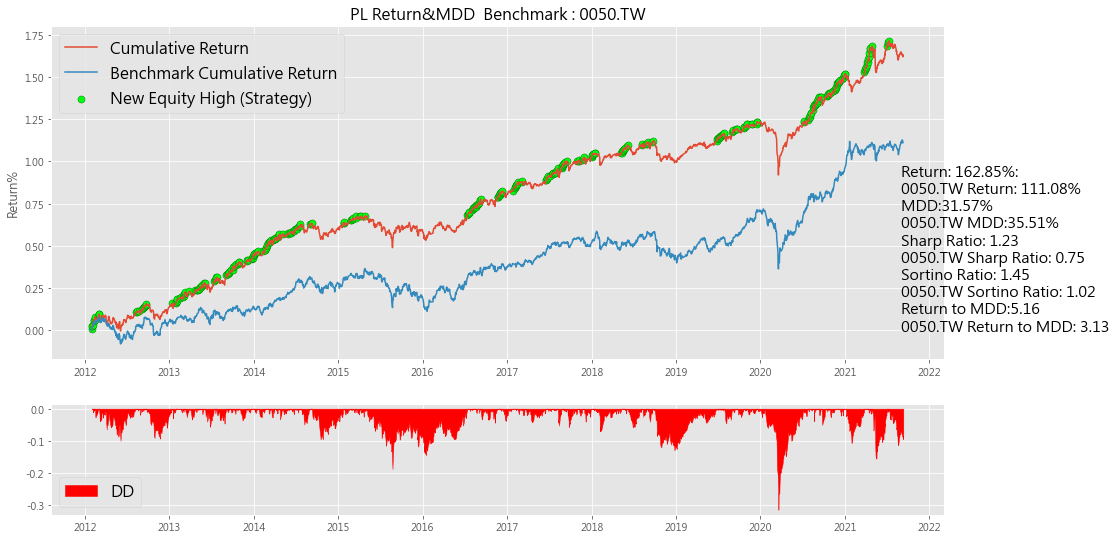

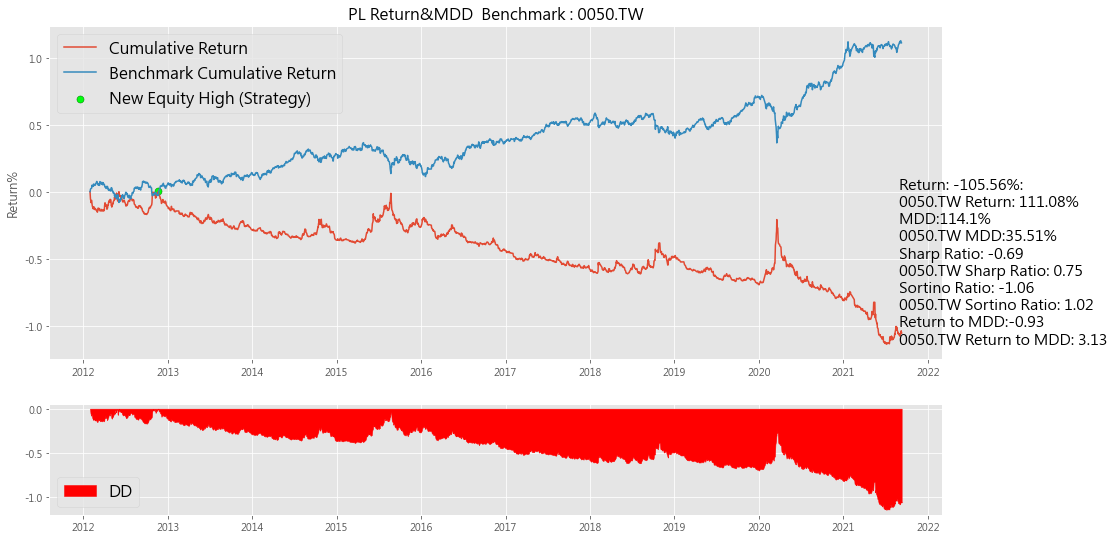

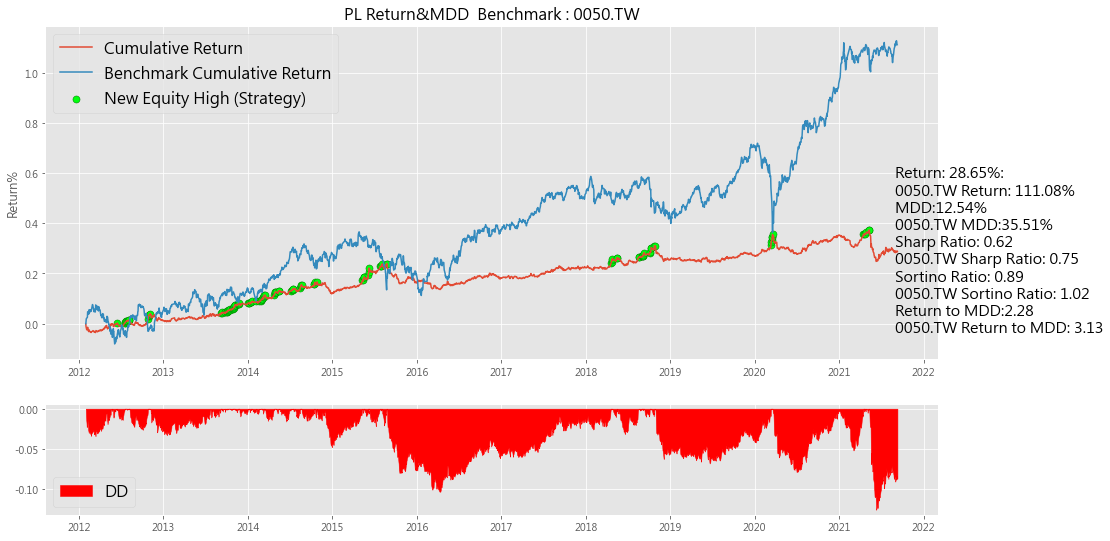

In [28]:
for i in [ret_long_df,ret_short_df,ret_port_df] :
    equity_plot(i.cumsum(),'0050.TW','PL',1)

挑選股票次數

<AxesSubplot:ylabel='value'>

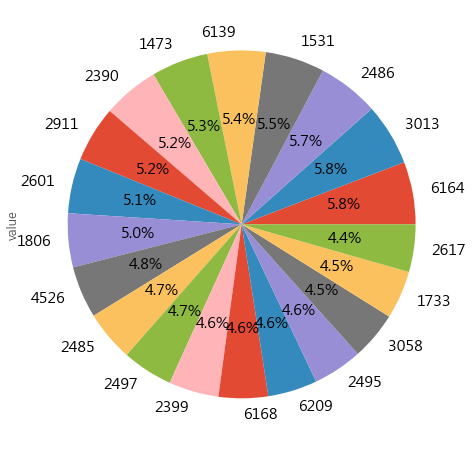

In [53]:
tic_short_df.melt().value.dropna().value_counts()[0:20].plot(kind = 'pie',figsize = (20,8),fontsize = 15,rot=0, autopct='%1.1f%%')

In [54]:
long_tick_df = tic_short_df.melt()
long_tick_df = long_tick_df.rename(columns = {"value":"公司簡稱"})
long_tick_df

variable  公司簡稱
0            0  6277
1            0  2538
2            0  8039
3            0  8039
4            0  4526
...        ...   ...
8952        52  2474
8953        52  2474
8954        52  1455
8955        52  1455
8956        52  1907

[8957 rows x 2 columns]

In [55]:
long_tick_df = long_tick_df.merge(industry)

<AxesSubplot:ylabel='TSE新產業_名稱'>

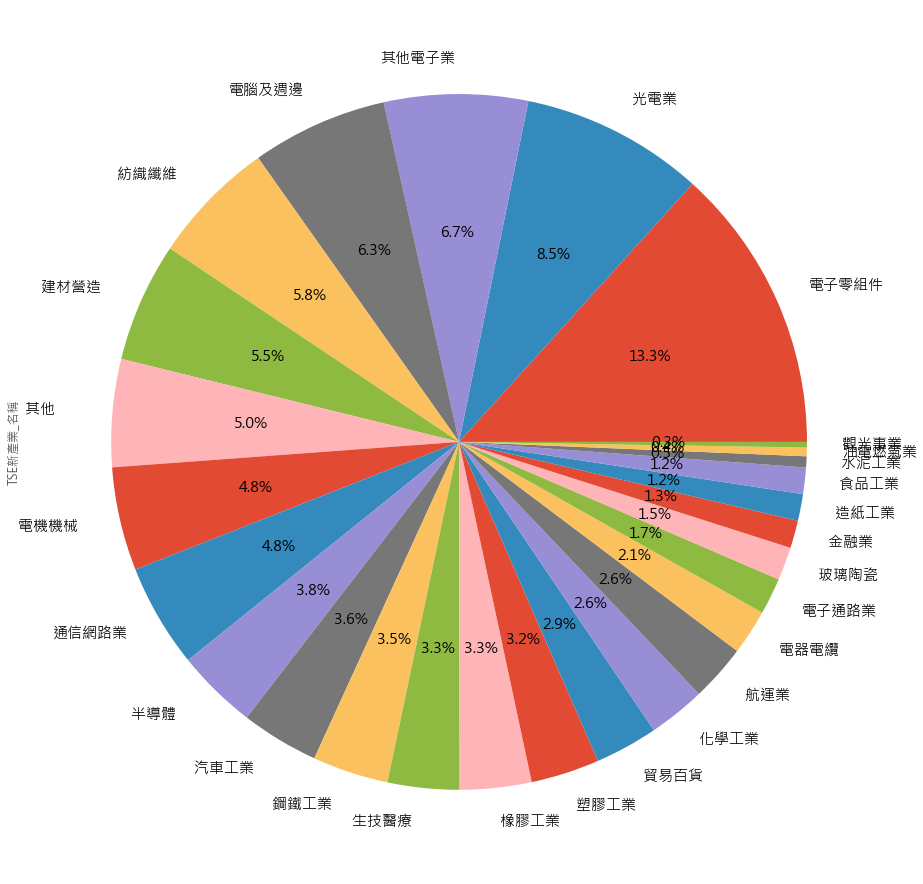

In [56]:
long_tick_df.TSE新產業_名稱.value_counts().plot(kind = 'pie',figsize = (40,16),fontsize = 15,rot=0, autopct='%1.1f%%')

因子分層

In [56]:
ret_dic = {}

In [57]:
for z in range(1,cut_size+1) :
    ret_long_list = []
    ret_short_list = []
    tic_long_list = []
    tic_short_list = []
    ret_port_list = []

    cut = z
    cost = -0.001425

    # data1 = signal_df
    data1 = signal_df
    # data2 = stock_df
    # data3 = stock_21day_high

    for i in range(1,len(rebalance_list['start'])) :

        ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],
                                       stock_signal(rebalance_list['end'][i-1],cut_size,cut,data1)].pct_change().fillna(0).T.mean()

        tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],
                                       stock_signal(rebalance_list['end'][i-1],cut_size,cut,data1)].columns

        ret_long[0] = cost

        ret_long_list.append(ret_long)
        tic_long_list.append(tic_long)

        ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
        tic_long_df = pd.DataFrame(tic_long_list)
        
    ret_dic.setdefault(("cut_"+str(z)),ret_long_df)

In [58]:
ret_df = pd.DataFrame(ret_dic['cut_1'])
for i in range(2,cut_size+1) :
    df = ret_dic['cut_'+str(i)]
    ret_df = pd.concat([ret_df,df],axis = 1)
ret_df

0         0         0         0         0
年月日                                                         
2012-01-31 -0.001425 -0.001425 -0.001425 -0.001425 -0.001425
2012-02-01  0.028578  0.021175  0.014619  0.009769  0.008972
2012-02-02  0.027106  0.017528  0.016773  0.011624  0.018369
2012-02-03  0.006479  0.003204  0.003542  0.005331  0.000511
2012-02-04  0.018407  0.014497  0.007794  0.008040  0.006602
...              ...       ...       ...       ...       ...
2021-09-06 -0.015989 -0.012508 -0.015638 -0.010016 -0.012359
2021-09-07  0.001759 -0.002840  0.000745 -0.003901  0.002293
2021-09-08 -0.016046 -0.018448 -0.015103 -0.011967 -0.010597
2021-09-09  0.011330  0.010317  0.005889  0.007618  0.003780
2021-09-10  0.004720  0.008276  0.010449  0.007216  0.005906

[2366 rows x 5 columns]

In [59]:
ret_df.columns = ['cut_'+str(i) for i in range(1,cut_size+1)]

<AxesSubplot:title={'center':'因子單調性'}, xlabel='年月日'>

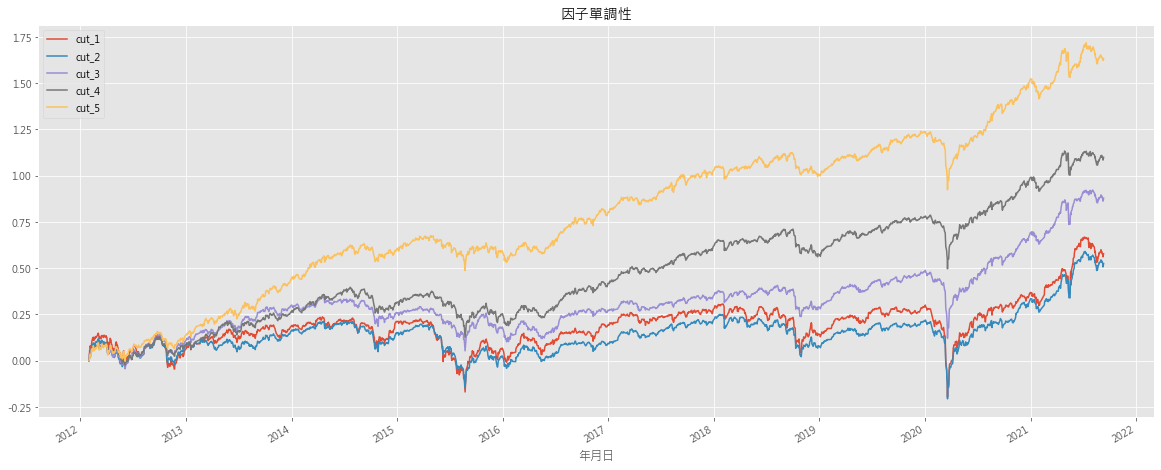

In [60]:
ret_df.cumsum().plot(figsize = (20,8), title = '因子單調性')

Interact

In [19]:
def factor_plot(cut) :
    ret_df[cut].cumsum().plot(figsize = (20,8), title = '因子單調性')

In [20]:
interact(factor_plot,cut = ret_df.columns)

interactive(children=(Dropdown(description='cut', options=('cut1', 'cut2', 'cut3', 'cut4', 'cut5', 'cut6', 'cu…

<function __main__.factor_plot(cut)>

雙因子

In [120]:
ret_pct_df = stock_df.pct_change().rolling(14).std().fillna(0)
ret_pct_df

1101      1102      1103      1104      1108      1109  \
年月日                                                                      
2012-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2021-09-27  0.012275  0.013500  0.022745  0.008454  0.019393  0.028725   
2021-09-28  0.012347  0.013427  0.022628  0.007975  0.019102  0.028899   
2021-09-29  0.012658  0.013906  0.022765  0.008944  0.019102  0.029467   
2021-09-30  0.012565  0.013709  0.021943  0.008832  0.018182  0.028619   
2021-10-01  0.013308  0.013538  0.023702  0.009844  0.019226  0.029322   

                1110      1201      1203      1210      1215      1216  \
年月日                                                                      
2012-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2021-09-27  0.037905  0.009028  0.007424  0.009009  0.008635  0.009728   
2021-09-28  0.039076  0.008372  0.007389  0.008527  0.008945  0.010060   
2021-09-29  0.044141  0.008857  0.007524  0.008896  0.009570  0.009553   
2021-09-30  0.047118  0.008748  0.007142  0.009031  0.009496  0.009621   
2021-10-01  0.048802  0.007939  0.007595  0.011163  0.009923  0.009990   

                1217      1218      1219      1220      1225      1227  \
年月日                                                                      
2012-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2021-09-27  0.020836  0.010270  0.008191  0.008635  0.013896  0.005666   
2021-09-28  0.019769  0.010128  0.008173  0.008498  0.011262  0.005643   
2021-09-29  0.020149  0.010919  0.008767  0.008640  0.011635  0.006375   
2021-09-30  0.018635  0.010545  0.009146  0.007658  0.011667  0.006466   
2021-10-01  0.018713  0.010513  0.010485  0.008451  0.012714  0.006617   

                1229      1231      1232      1233      1234      1235  \
年月日                                                                      
2012-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2012-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2021-09-27  0.029521  0.010459  0.007293  0.004266  0.006385  0.026720   
2021-09-28  0.029522  0.009988  0.006723  0.004379  0.006524  0.025375   
2021-09-29  0.029381  0.010449  0.006458  0.004249  0.006918  0.025483   
2021-09-30  0.029550  0.009822  0.005957  0.006722  0.006734  0.021002   
2021-10-01  0.030307  0.010027  0.007399  0.008073  0.007031  0.021102   

                1236      1301      1303      1304      1305      1307  \
年月日                                                                      
2012-01-02  0.00

先融資在股價動能

融券維持率top20%/報酬率標準差top20%


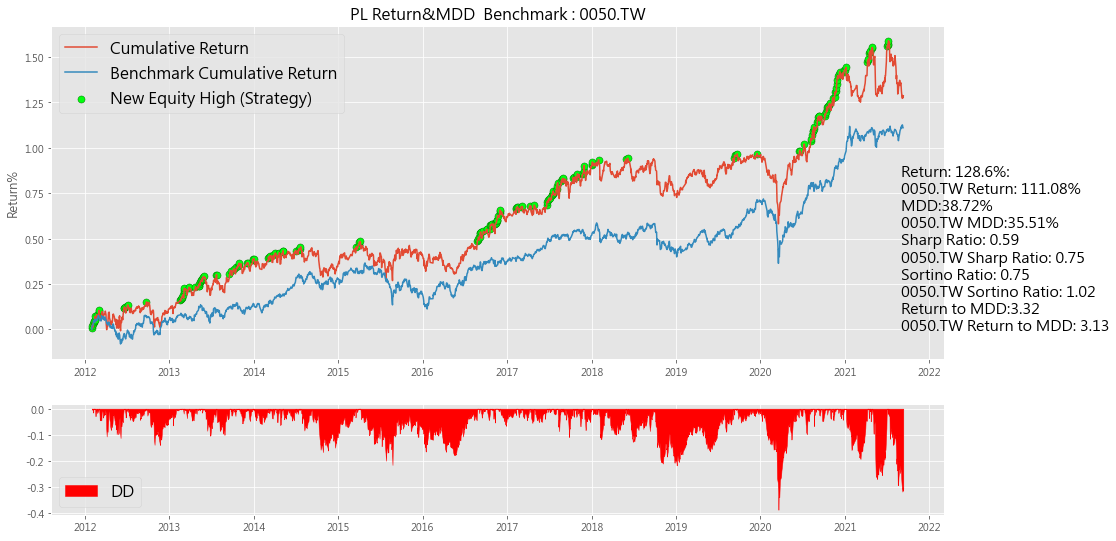

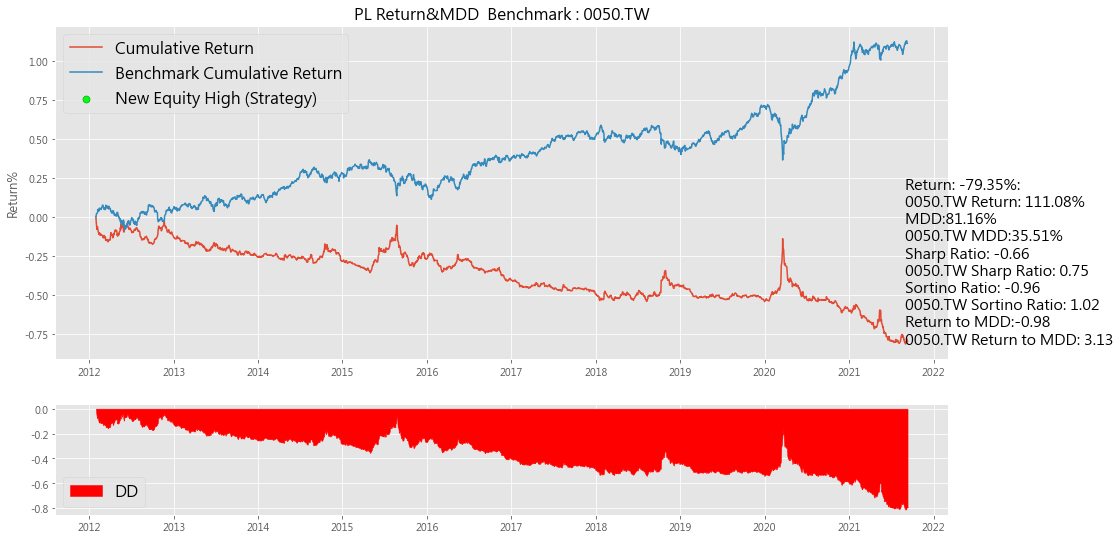

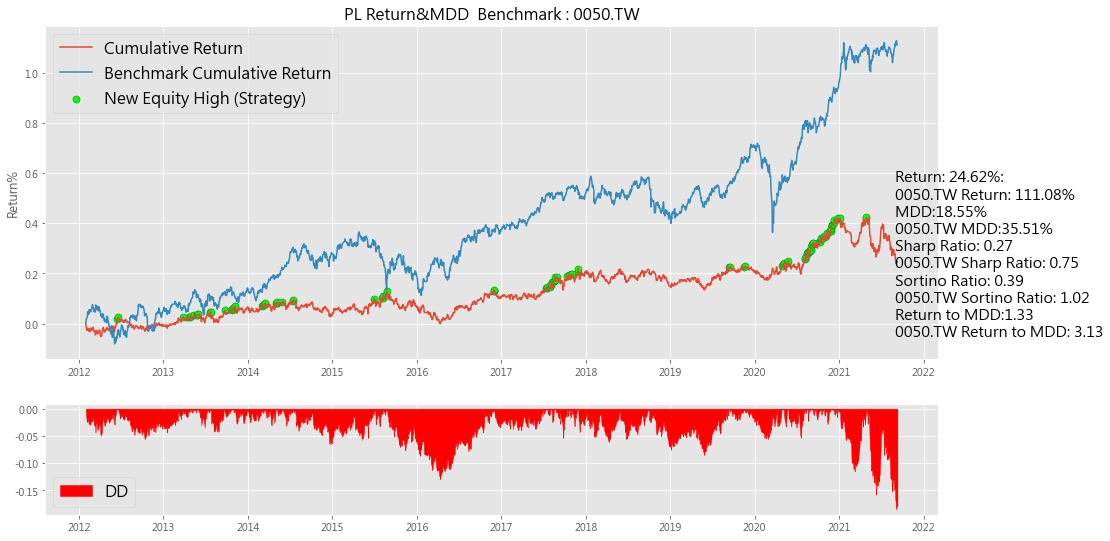

融券維持率top20%/報酬率標準差low20%


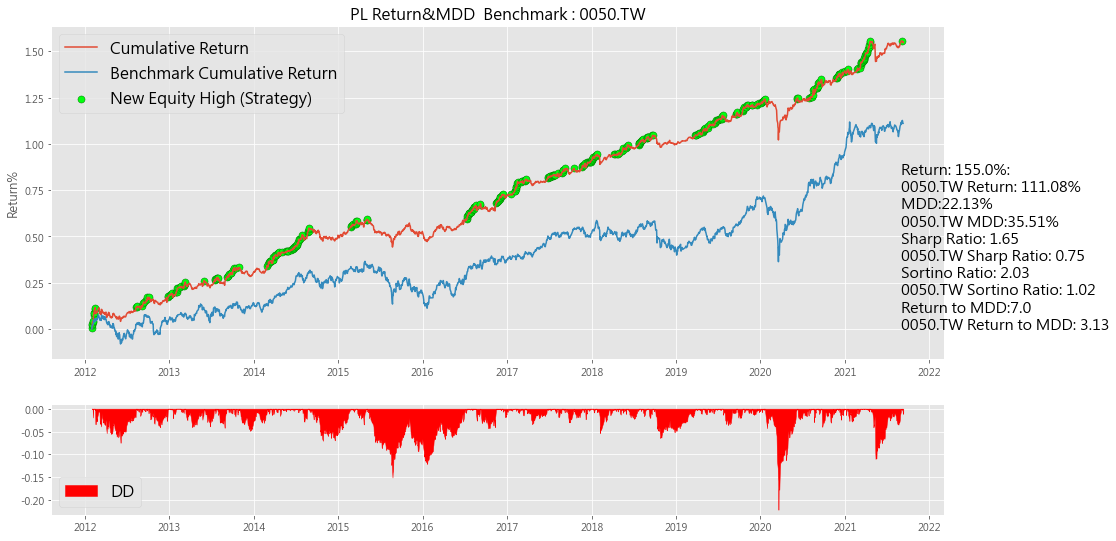

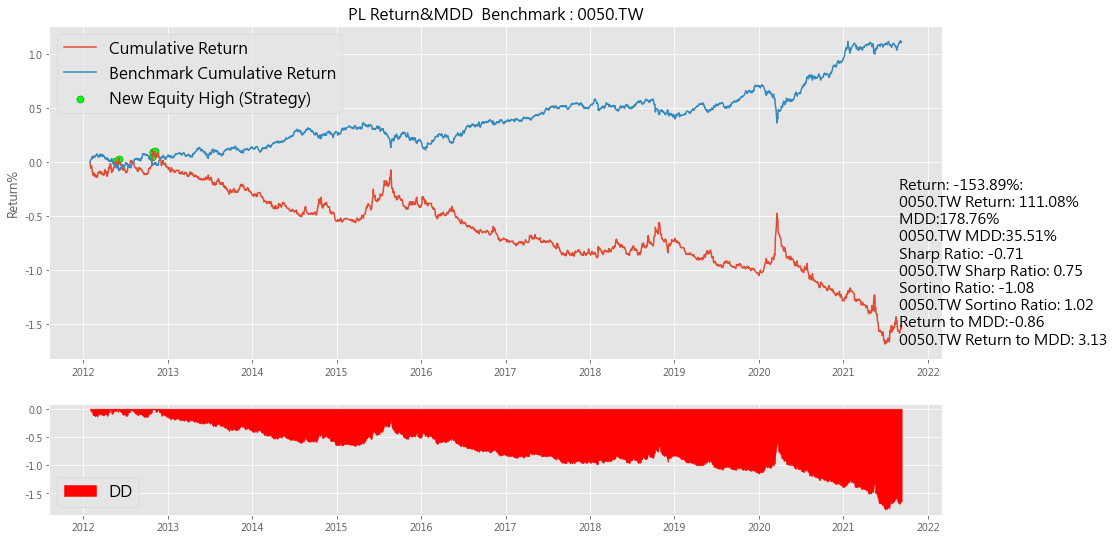

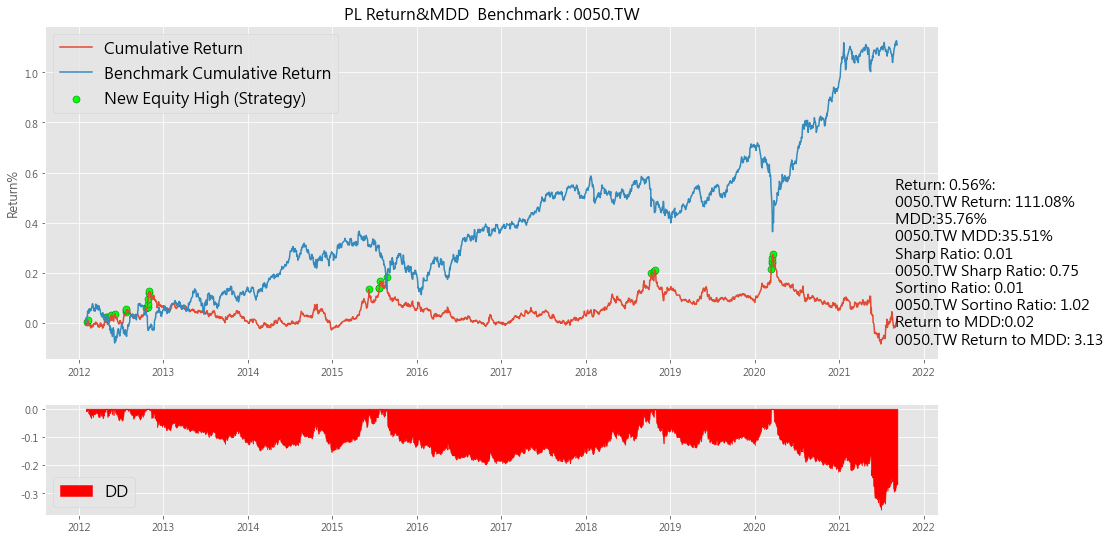

融券維持率low20%/報酬率標準差top20%


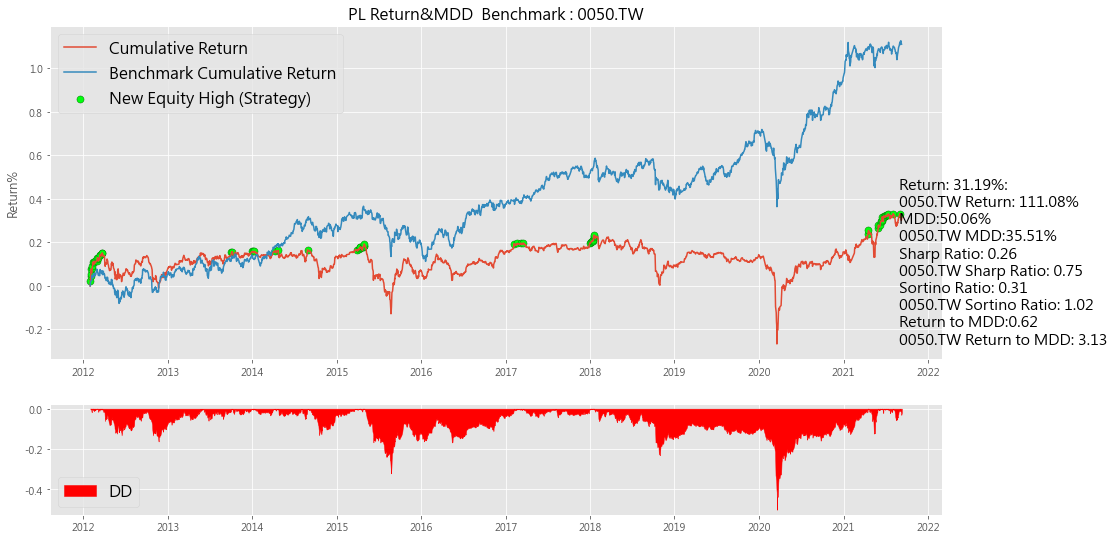

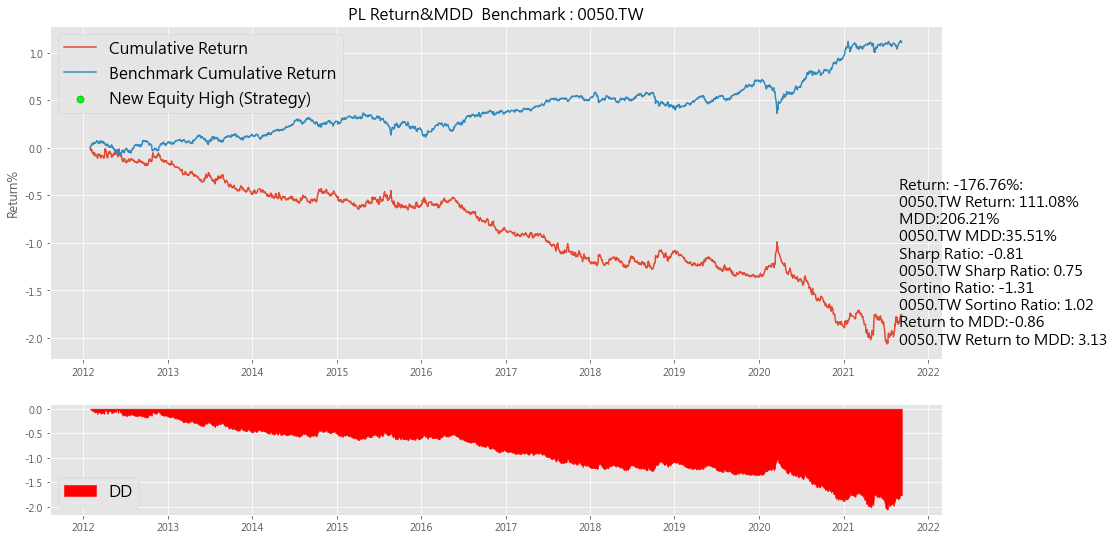

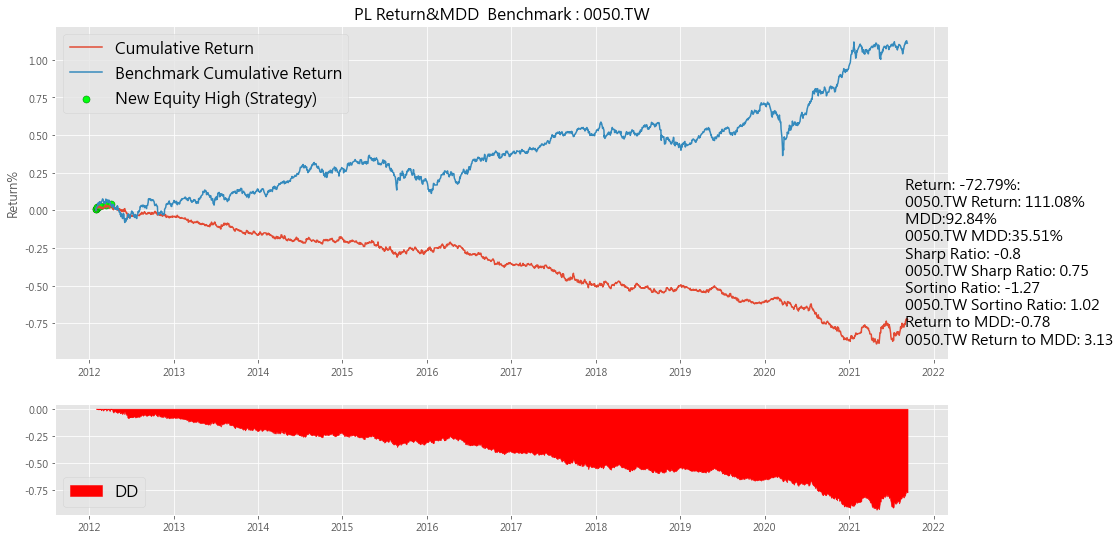

融券維持率low20%/報酬率標準差low20%


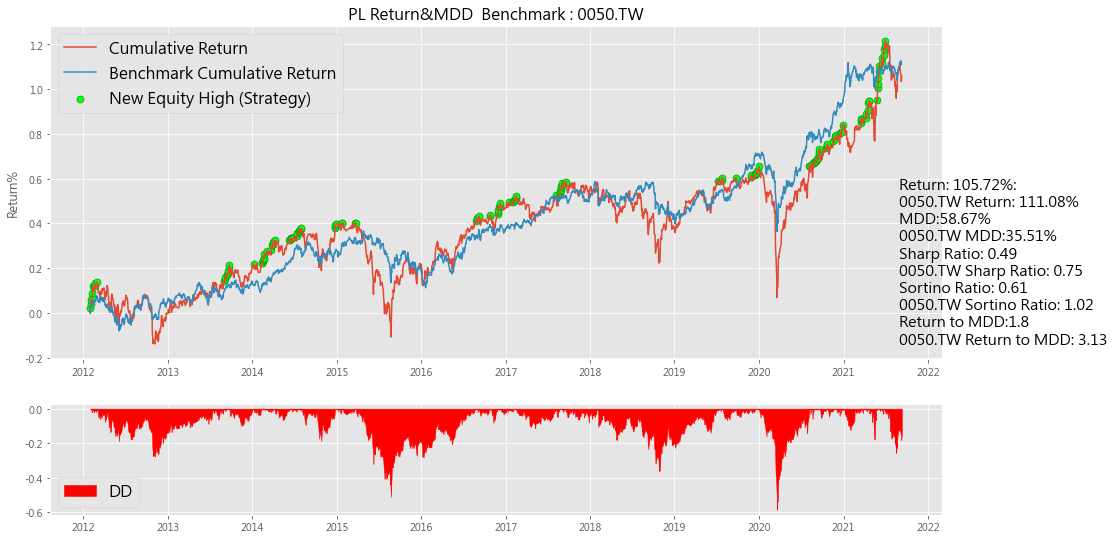

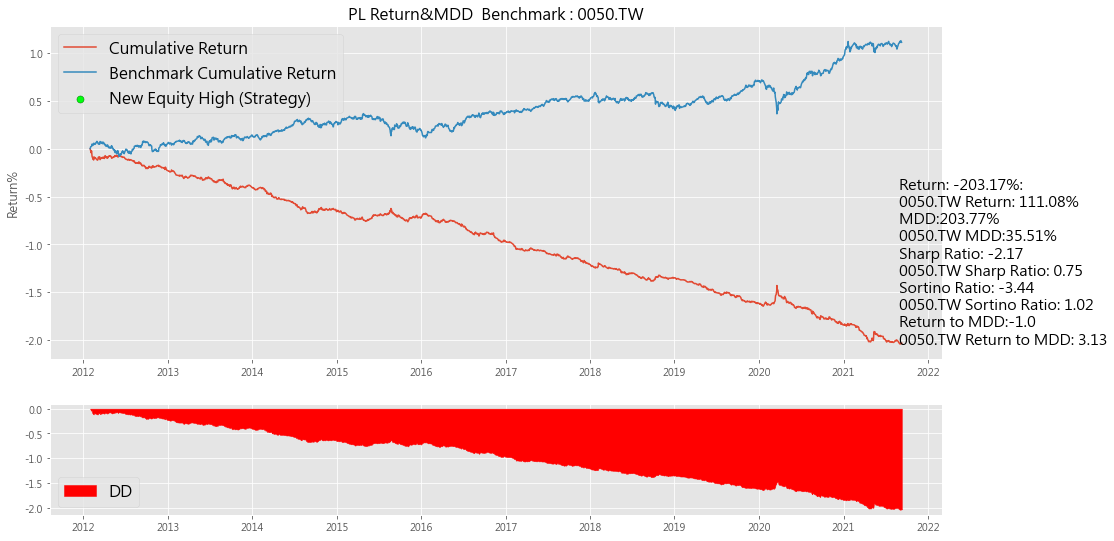

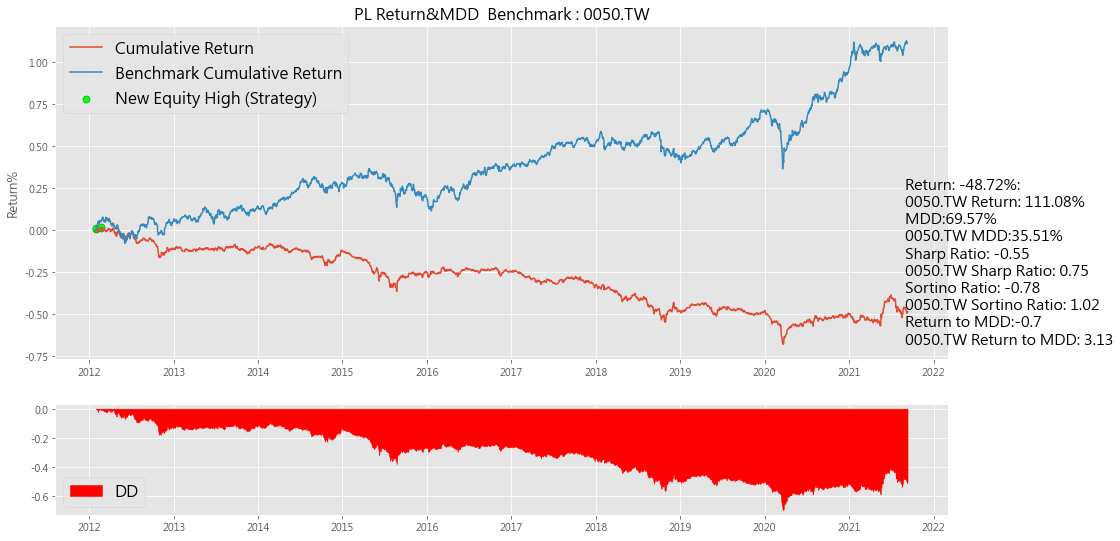

In [125]:
cut_matrix = [[5,1,5,1],
              [5,1,1,5],
             [1,5,1,5],
             [1,5,5,1]]

cut_name = ['融券維持率top20%/報酬率標準差top20%','融券維持率top20%/報酬率標準差low20%','融券維持率low20%/報酬率標準差top20%','融券維持率low20%/報酬率標準差low20%']

portfolio_df = {}
for m in range(0,4) :
    ret_long_list = []
    ret_short_list = []
    tic_long_list = []
    tic_short_list = []
    ret_port_list = []

    long_cut_1 = cut_matrix[m][0]
    short_cut_1 = cut_matrix[m][1]
    
    long_cut_2 = cut_matrix[m][2]
    short_cut_2 = cut_matrix[m][3]
    cut_size = 5
    cost = -0.001425

   

    # data1 = signal_df
    data1 = lend_df
    data2 = ret_pct_df
    # data3 = stock_21day_high

    for i in range(1,len(rebalance_list['start'])) :

        long_signal = stock_multi_signal(rebalance_list['end'][i-1],cut_size,long_cut_1,long_cut_2,data1,data2)

        short_signal = stock_multi_signal(rebalance_list['end'][i-1],cut_size,short_cut_1,short_cut_2,data1,data2)

        ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

        tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

        ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

        tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns

        if long_signal.values.squeeze() != [] :
            ret_long[0] = cost
            ret_short[0] = cost

        ret_long_list.append(ret_long)
        tic_long_list.append(tic_long)

        ret_short_list.append(ret_short)
        tic_short_list.append(tic_short)

        ret_port_list.append((ret_long+ret_short)/2)

    ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
    tic_long_df = pd.DataFrame(tic_long_list)
    ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
    tic_short_df = pd.DataFrame(tic_short_list)
    ret_port_df = (ret_long_df+ret_short_df)/2

    sharpe = round(ret_long_df.mean()/ret_long_df.std()*(252**(1/2)),2)
    mdd = (ret_long_df.cumsum().cummax()-ret_long_df.cumsum()).max()
    ret_mdd =round((ret_long_df.cumsum().iloc[-1])/mdd,2)

    portfolio_df[cut_name[m]] = [str(round(ret_long_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_short_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_port_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                  sharpe.squeeze(),
                                  str(round(mdd.squeeze(),4)*100) + '%',
                                  ret_mdd.squeeze()]
    print(cut_name[m])
    for i in [ret_long_df,ret_short_df,ret_port_df] :
        equity_plot(i.cumsum(),'0050.TW','PL',1)

In [124]:
multi_factor_df = pd.DataFrame(portfolio_df, index = ['做多','做空(不考慮融券費用&數量)','對沖','Sharpe','MDD','Return To MDD(做多)']).T
multi_factor_df.sort_values(['Return To MDD(做多)'],ascending = False)

做多        做空(不考慮融券費用&數量)                   對沖  \
融券維持率top20%/報酬率標準差low20%   155.0%              -153.89%  0.5599999999999999%   
融券維持率top20%/報酬率標準差top20%   128.6%               -79.35%               24.62%   
融券維持率low20%/報酬率標準差low20%  105.72%              -203.17%              -48.72%   
融券維持率low20%/報酬率標準差top20%   31.19%  -176.76000000000002%  -72.78999999999999%   

                         Sharpe     MDD Return To MDD(做多)  
融券維持率top20%/報酬率標準差low20%   1.65  22.13%               7.0  
融券維持率top20%/報酬率標準差top20%   0.59  38.72%              3.32  
融券維持率low20%/報酬率標準差low20%   0.49  58.67%               1.8  
融券維持率low20%/報酬率標準差top20%   0.26  50.06%              0.62

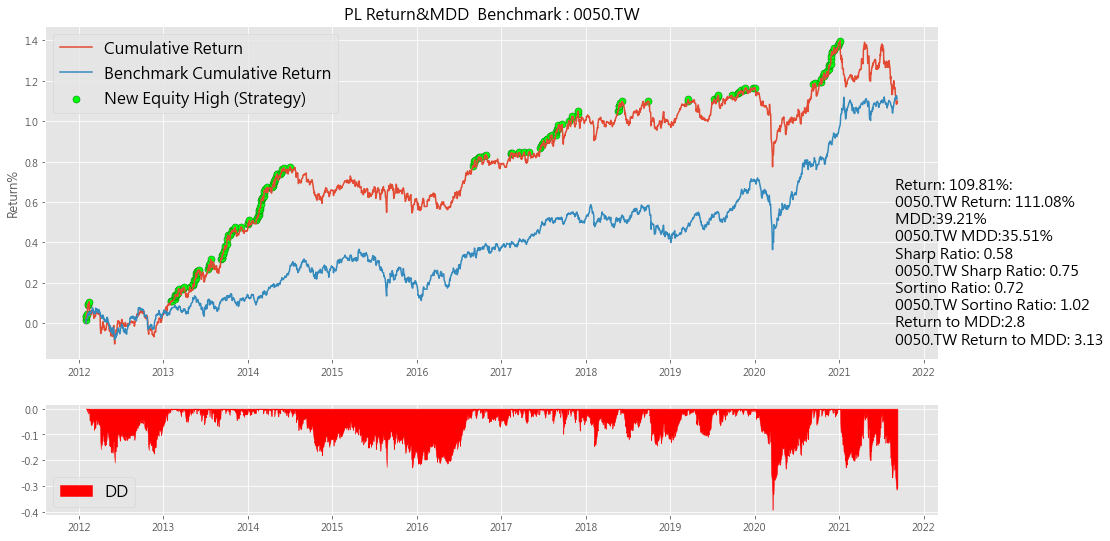

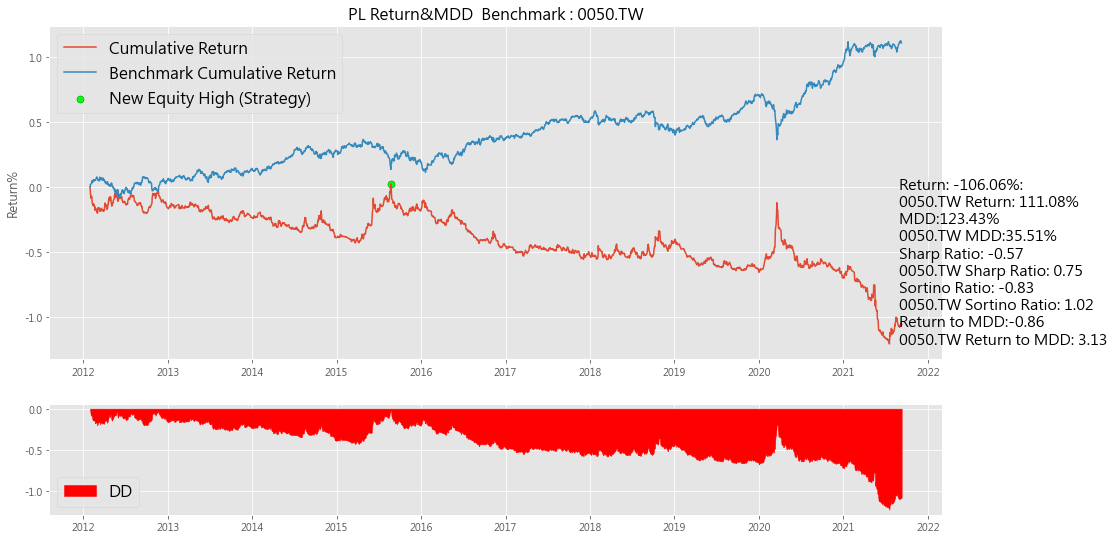

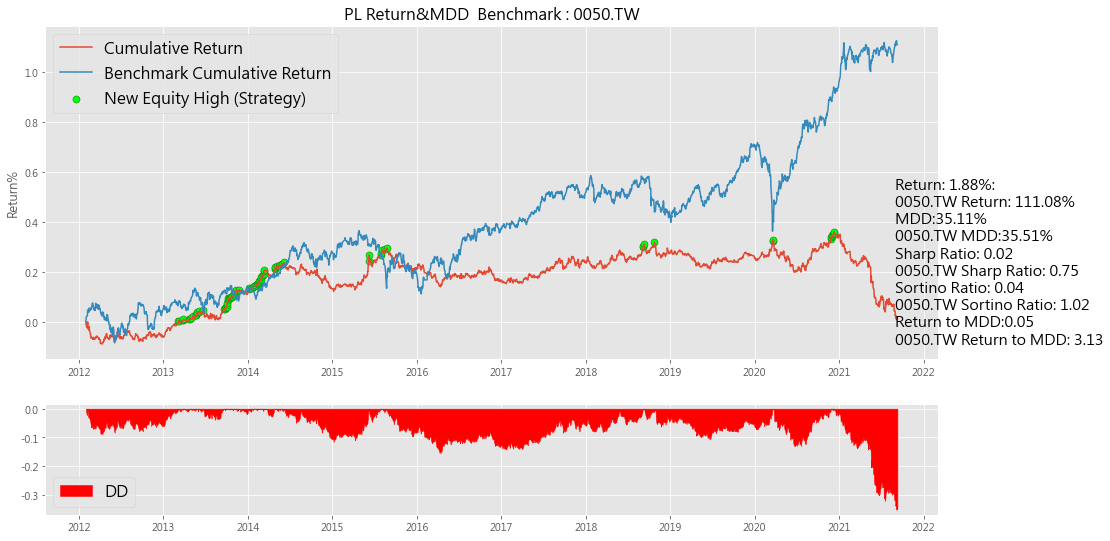

In [78]:
for i in [ret_long_df,ret_short_df,ret_port_df] :
    equity_plot(i.cumsum(),'0050.TW','PL',1)

先股價動能在融資

In [24]:
ret_long_list = []
ret_short_list = []
tic_long_list = []
tic_short_list = []
ret_port_list = []

long_cut_1 = 10
short_cut_1 = 1
long_cut_2 = 1
short_cut_2 = 10

cost = -0.001425

# data1 = signal_df
data2 = lend_df
data1 = ret_pct_df
# data3 = stock_21day_high

for i in range(1,len(rebalance_list['start'])) :
    
    long_signal = stock_multi_signal(rebalance_list['end'][i-1],long_cut_1,long_cut_2,data1,data2)
    
    short_signal = stock_multi_signal(rebalance_list['end'][i-1],short_cut_1,short_cut_2,data1,data2)
    
    
    ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()
    
    tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns
    
    ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()
    
    tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns
    
    ret_long[0] = cost
    ret_short[0] = cost
    
    ret_long_list.append(ret_long)
    tic_long_list.append(tic_long)
    
    ret_short_list.append(ret_short)
    tic_short_list.append(tic_short)
    
    ret_port_list.append((ret_long+ret_short)/2)

ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
tic_long_df = pd.DataFrame(tic_long_list)
ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
tic_short_df = pd.DataFrame(tic_short_list)
ret_port_df = (ret_long_df+ret_short_df)/2

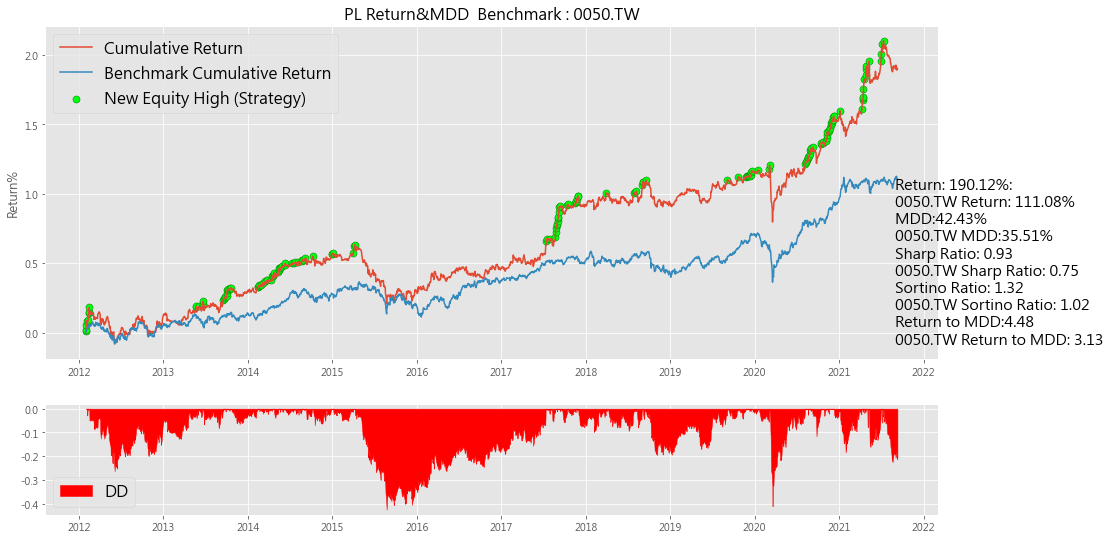

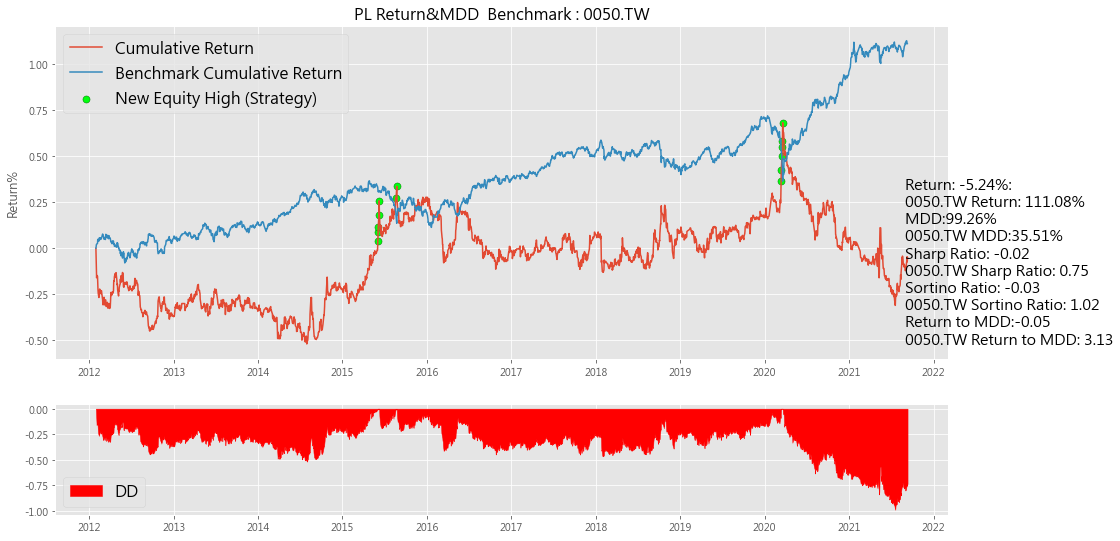

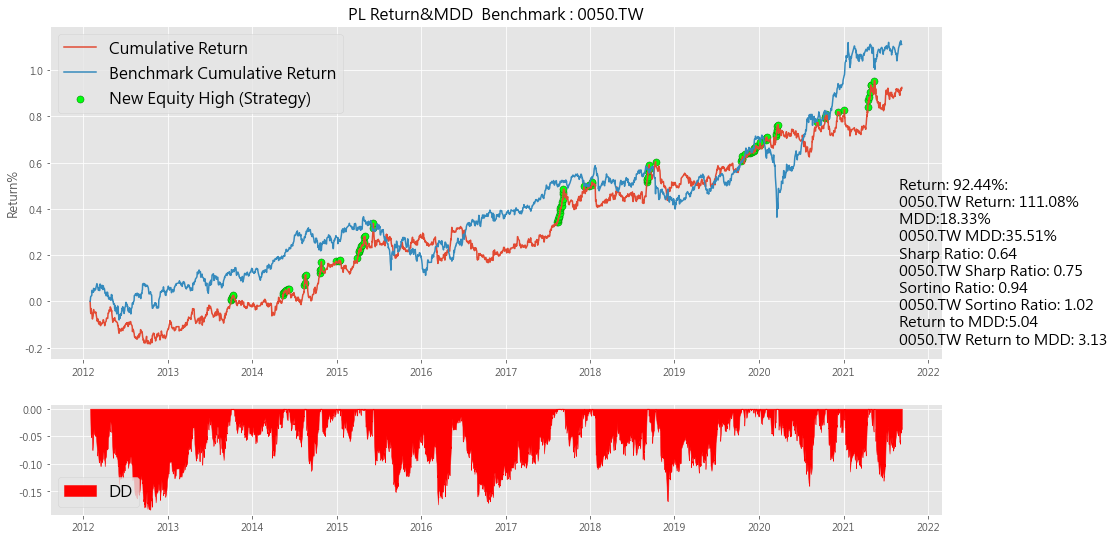

In [25]:
for i in [ret_long_df,ret_short_df,ret_port_df] :
    equity_plot(i.cumsum(),'0050.TW','PL',1)

產業回測

In [59]:
industry_list = []
for i in industry_df.TSE新產業_名稱.unique() :
    if len(industry_df[industry_df['TSE新產業_名稱'] == i]) >= 70 :
        print(i,'總上市公司數 : ',len(industry_df[industry_df['TSE新產業_名稱'] == i]))
        industry_list.append(i)

建材營造   總上市公司數 :  77
其他       總上市公司數 :  134
電子零組件 總上市公司數 :  206
電機機械   總上市公司數 :  92
生技醫療   總上市公司數 :  126
電腦及週邊 總上市公司數 :  108
半導體     總上市公司數 :  163
其他電子業 總上市公司數 :  84
通信網路業 總上市公司數 :  89
光電業     總上市公司數 :  118


In [64]:
industry_set = set(stock_set) & set(industry_df[industry_df['TSE新產業_名稱'] == "電子通路業"].公司簡稱.values)

In [65]:
for industry in industry_list :  
    print(industry,' : ' ,set(stock_set) & set(industry_df[industry_df['TSE新產業_名稱'] == industry].公司簡稱.values))

建材營造    :  {'3052', '2515', '2538', '5533', '5522', '2548', '2545', '2520', '2536', '2511', '5534', '2524', '2535'}
其他        :  {'9941', '9942', '9919', '9930', '9925', '9933', '9921', '9914', '9910', '1437', '9938', '9904', '9939', '9905', '9934', '9940', '9927', '9907'}
電子零組件  :  {'2428', '8039', '2367', '2421', '3037', '2328', '6224', '3044', '2402', '5469', '6213', '3058', '2355', '2392', '2420', '2467', '6191', '2493', '3023', '2313', '3003', '6282', '2308', '2368', '6153', '3042', '2383', '6269', '2385', '2484', '6108'}
電機機械    :  {'4526', '1519', '1514', '1504', '1503', '1507', '1532', '1531', '1537', '1535', '1517'}
生技醫療    :  {'1720', '1701', '1736', '1731', '1734', '1733', '1707'}
電腦及週邊  :  {'3013', '6277', '2382', '3231', '2376', '6166', '3005', '6206', '2324', '2356', '2395', '2377', '3017', '2353', '2399', '2362'}
半導體      :  {'8016', '2449', '5471', '6202', '2369', '6239', '2451', '3034', '3006', '2351', '6257', '2441', '2330', '2454'}
其他電子業  :  {'2464', '2390', '6196', 

產業別 :  建材營造  


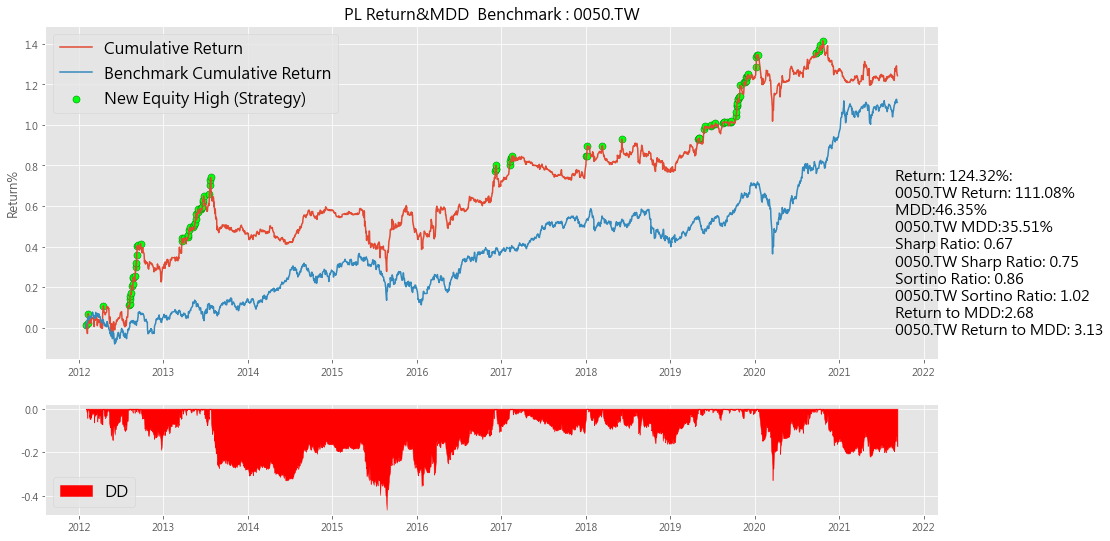

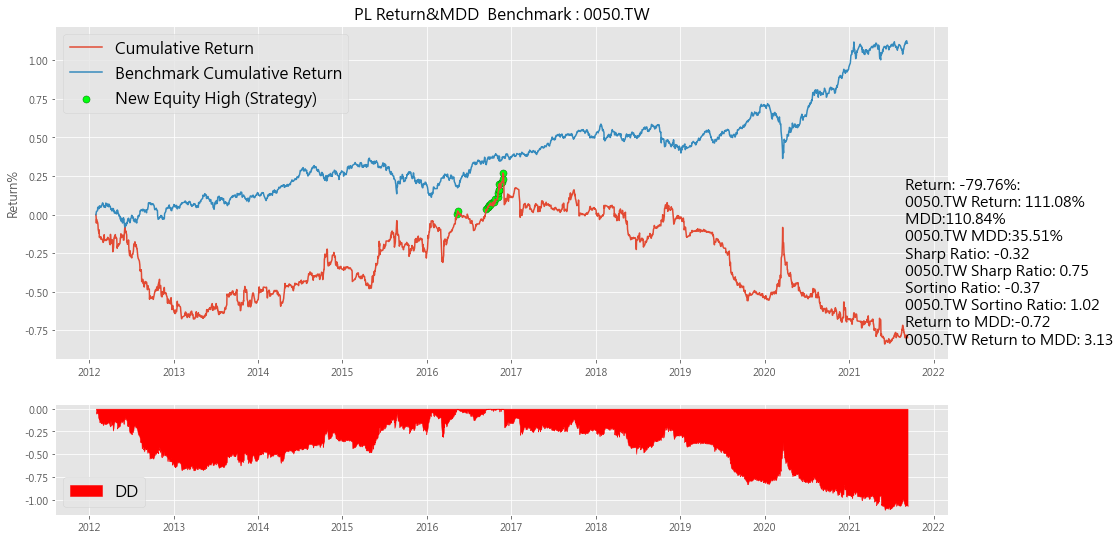

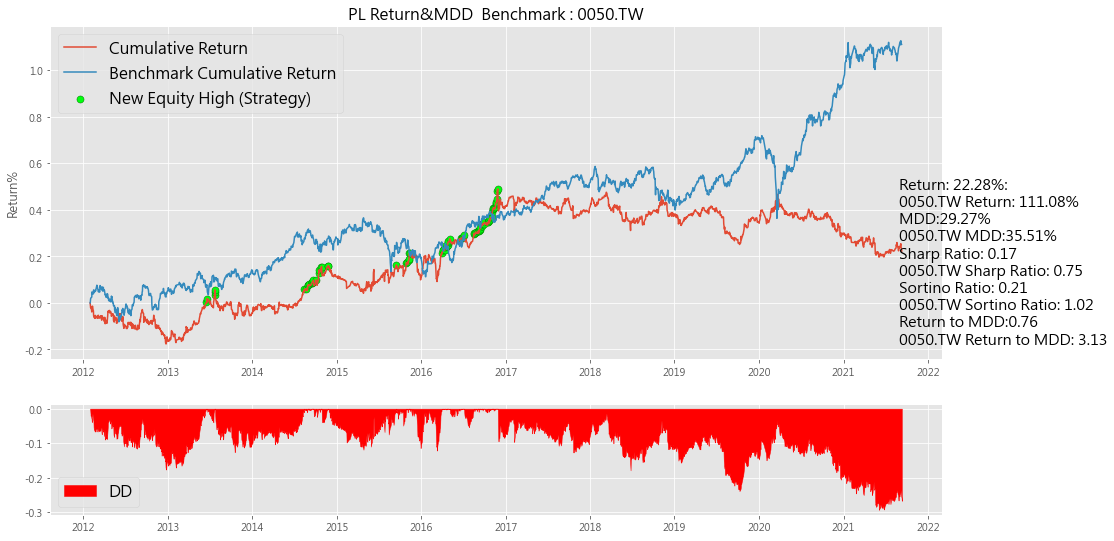

產業別 :  其他      


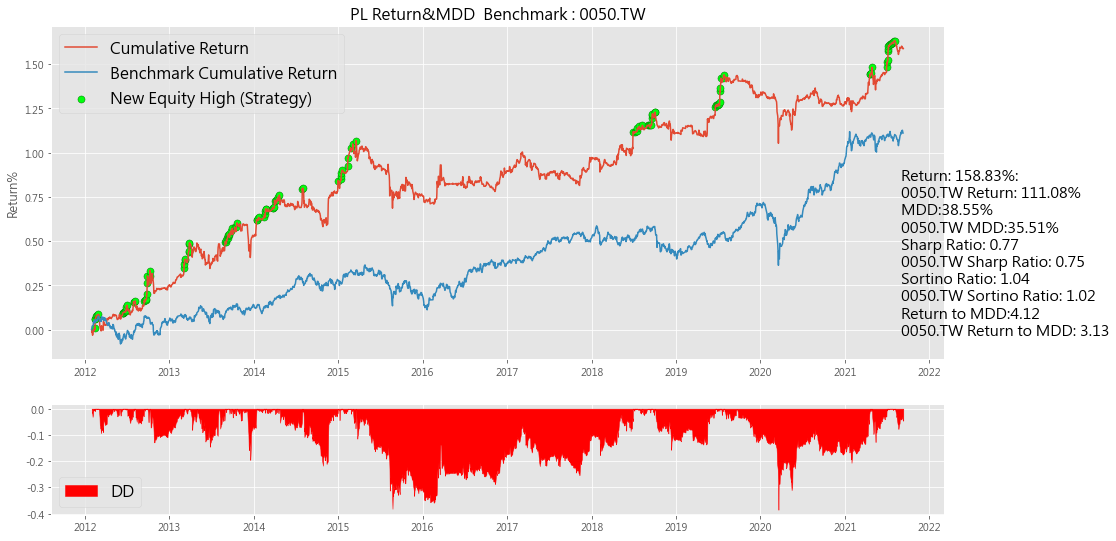

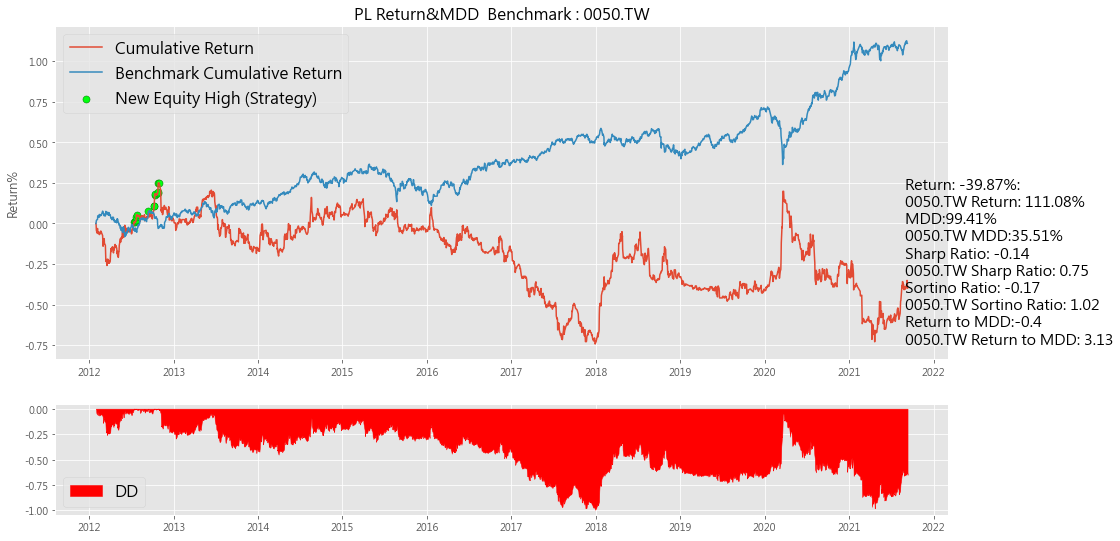

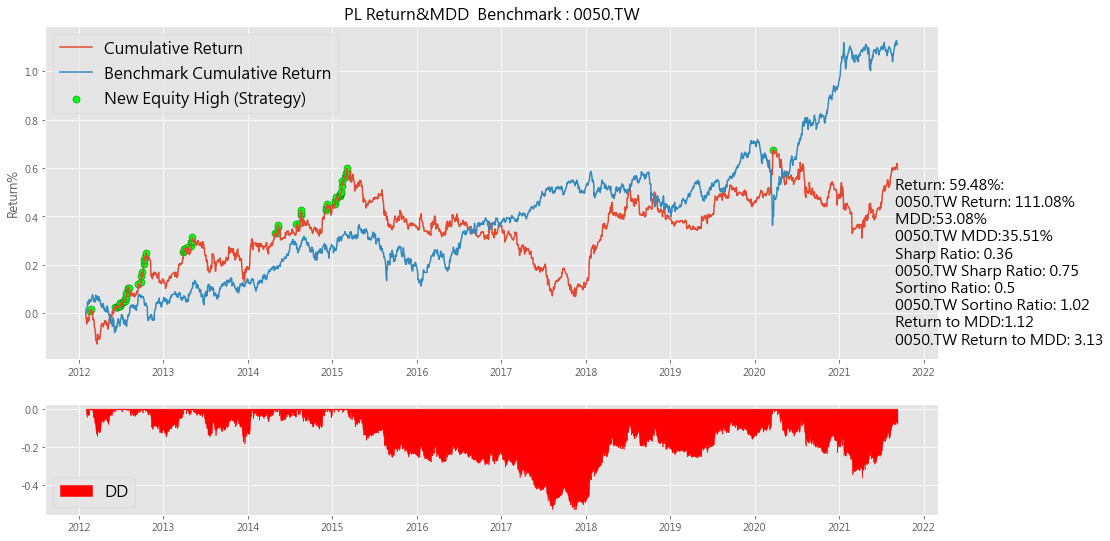

產業別 :  電子零組件


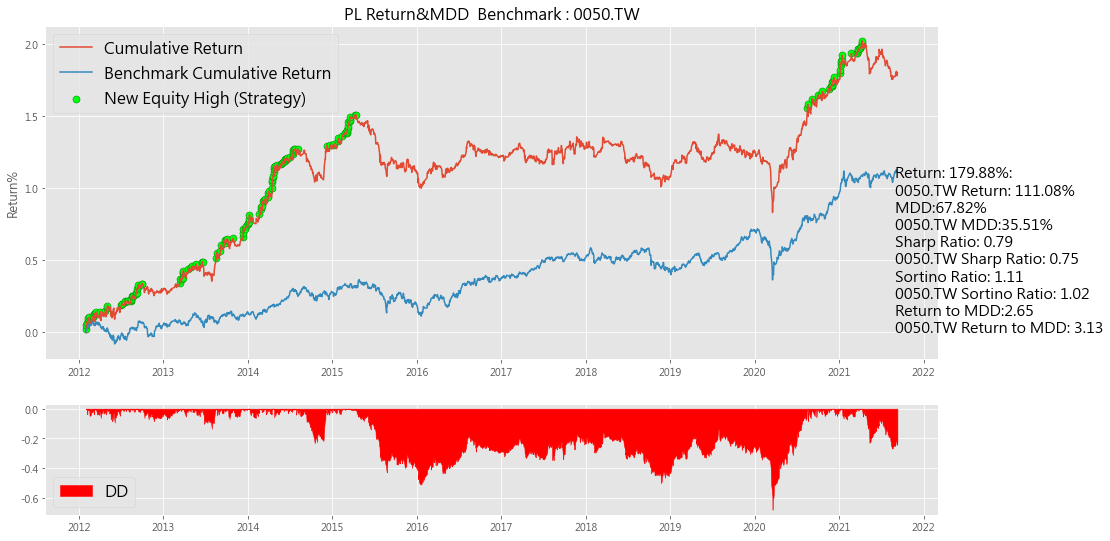

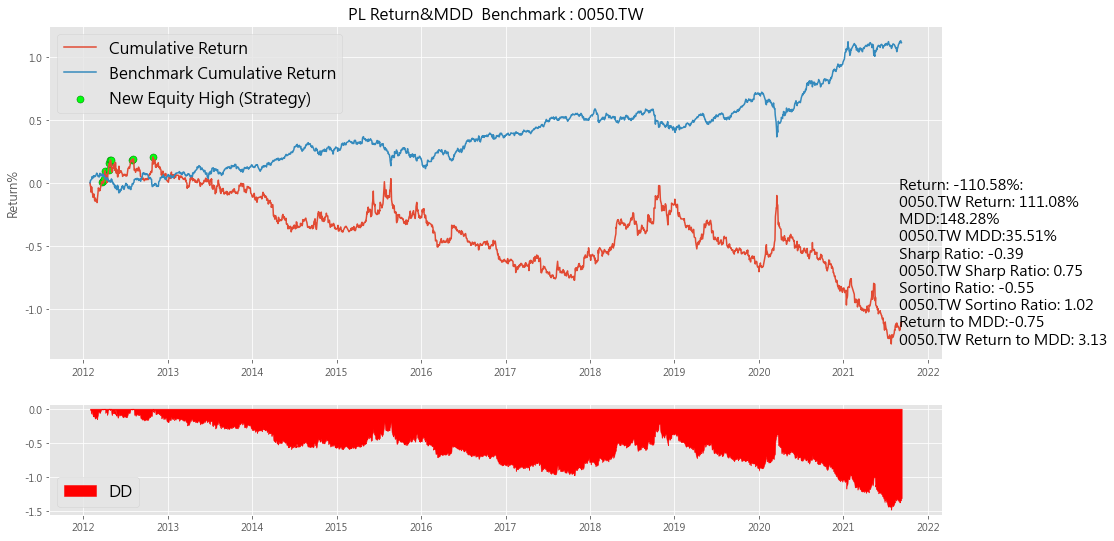

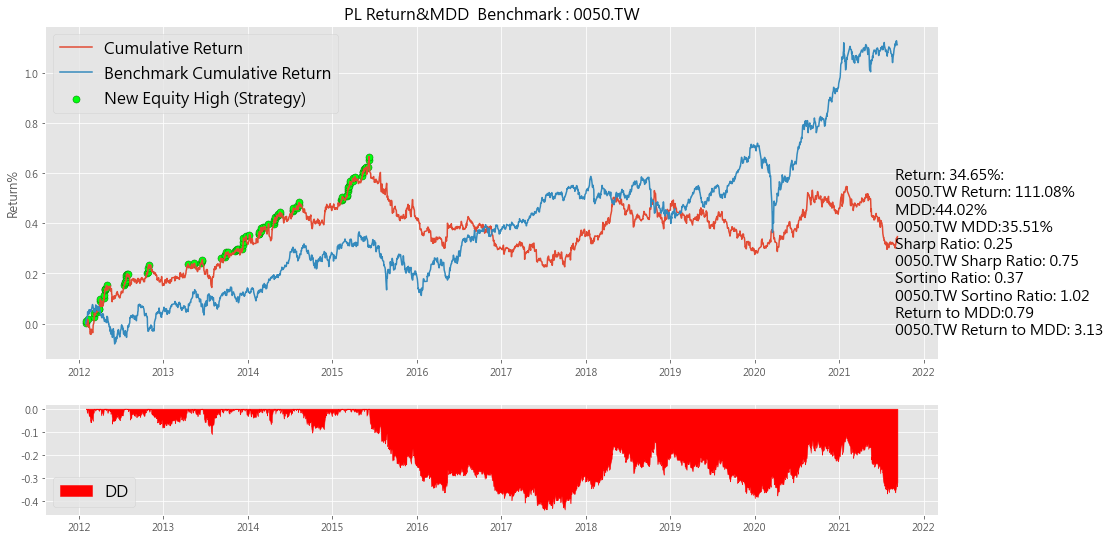

產業別 :  電機機械  


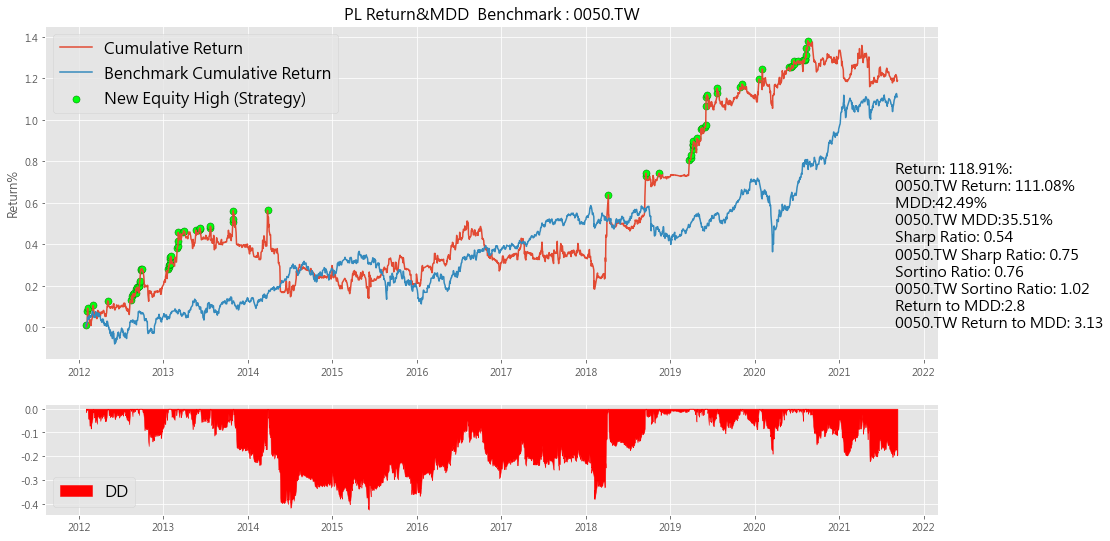

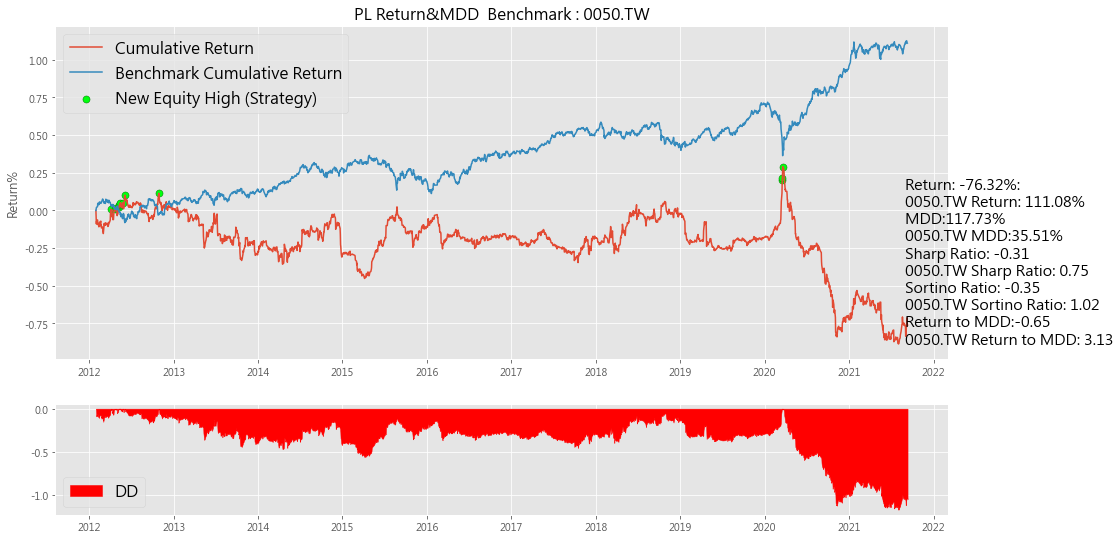

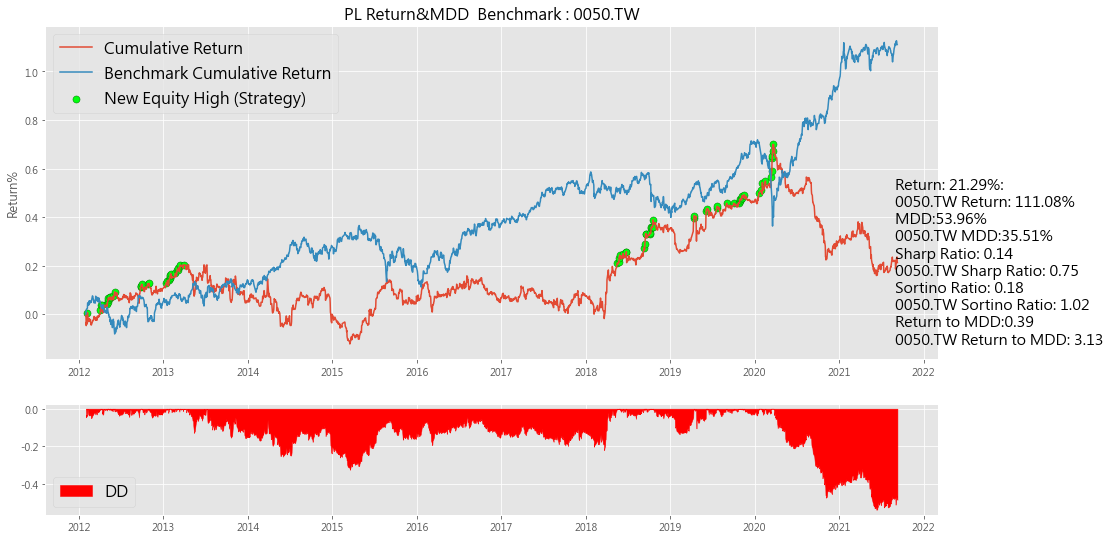

產業別 :  生技醫療  


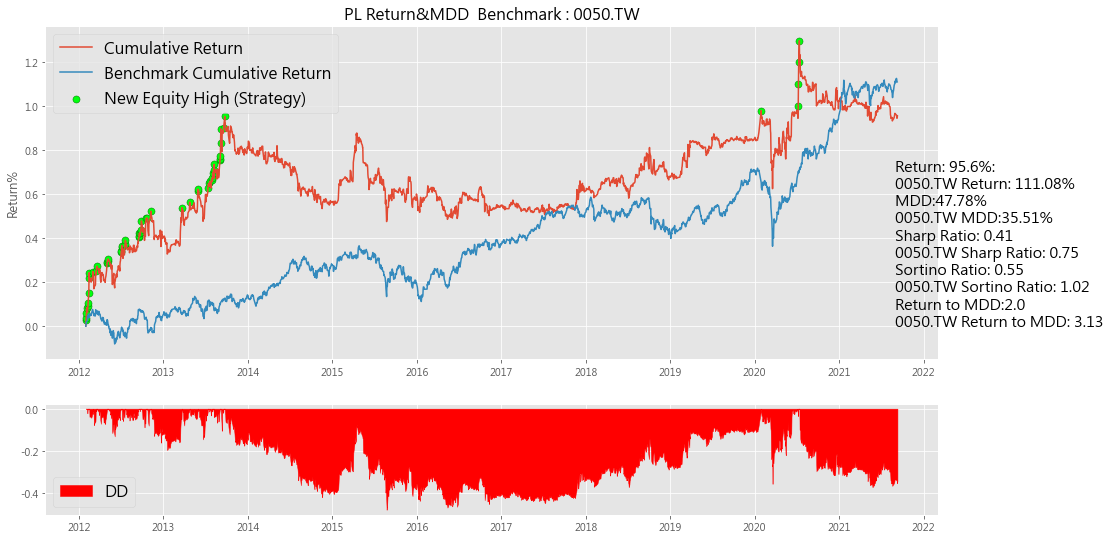

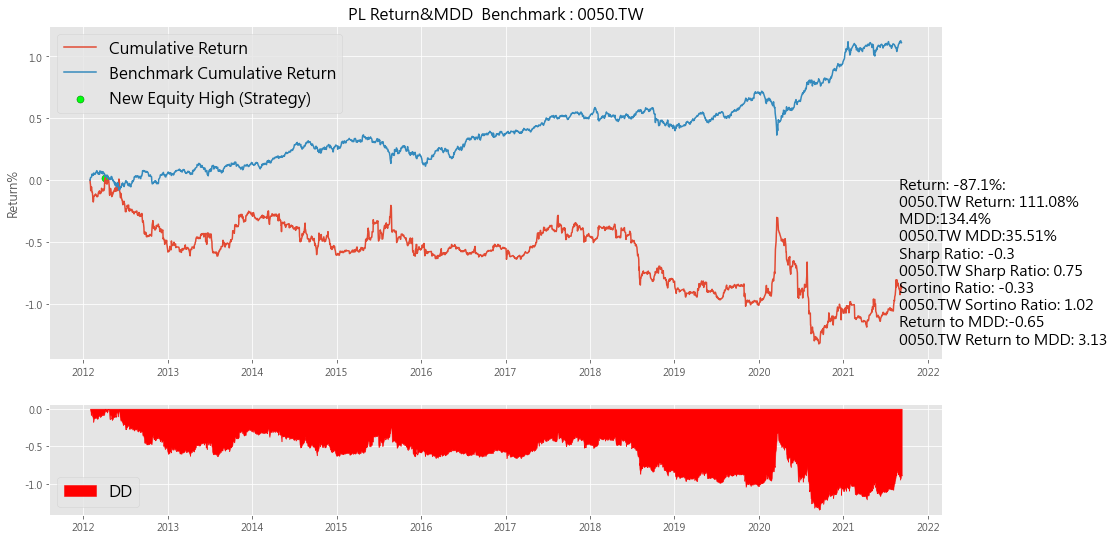

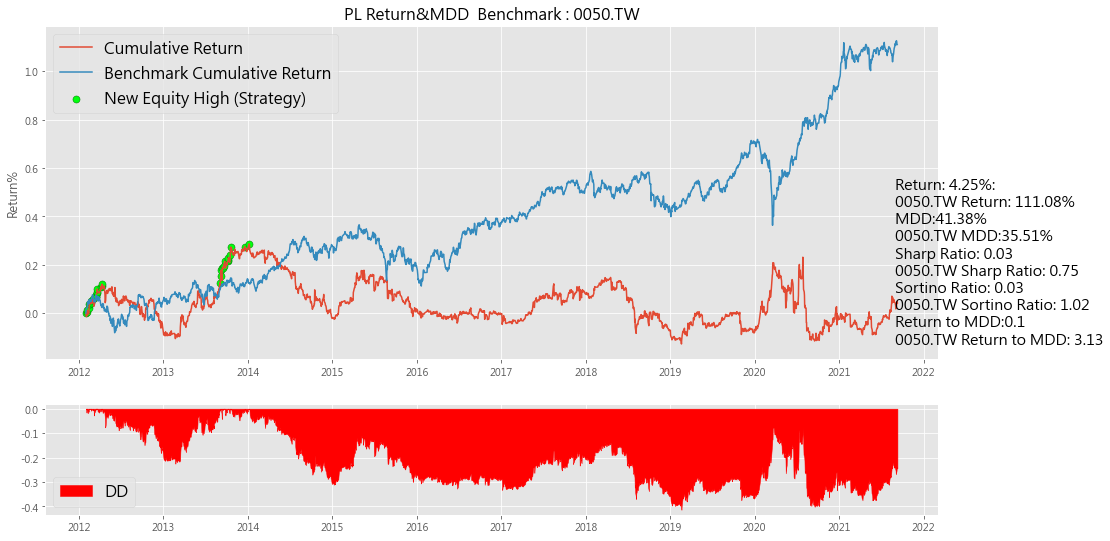

產業別 :  電腦及週邊


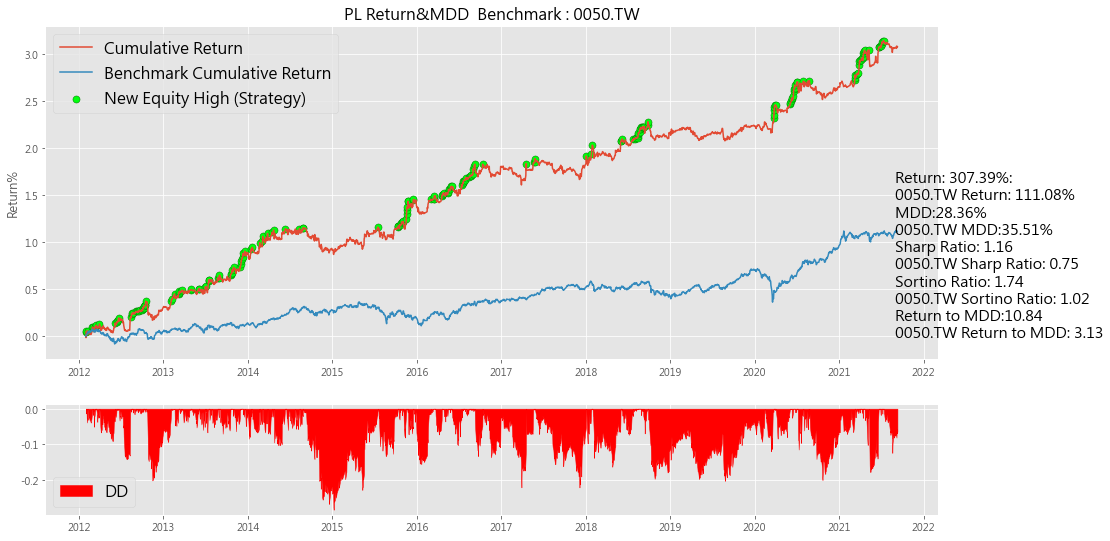

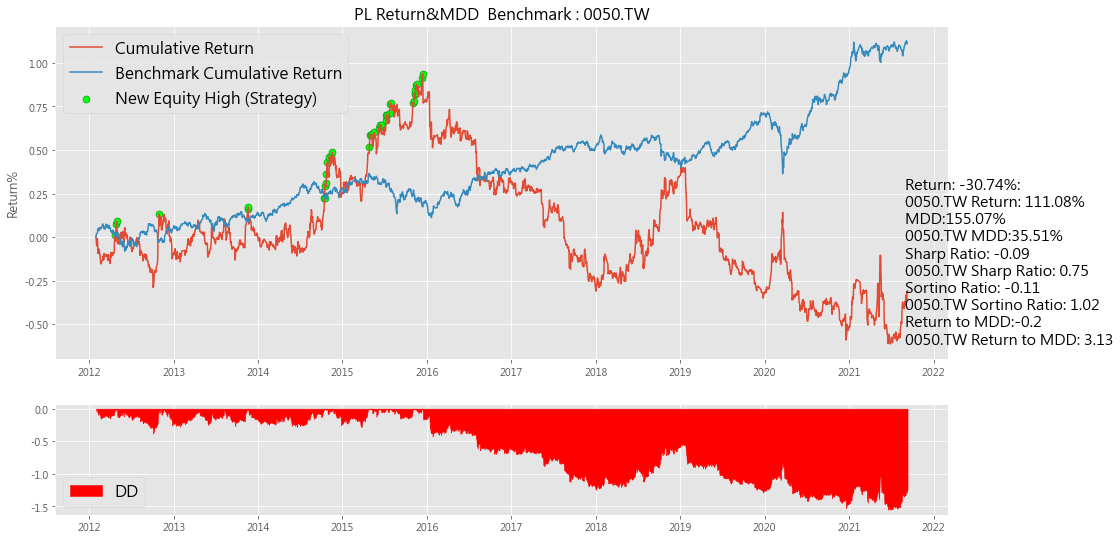

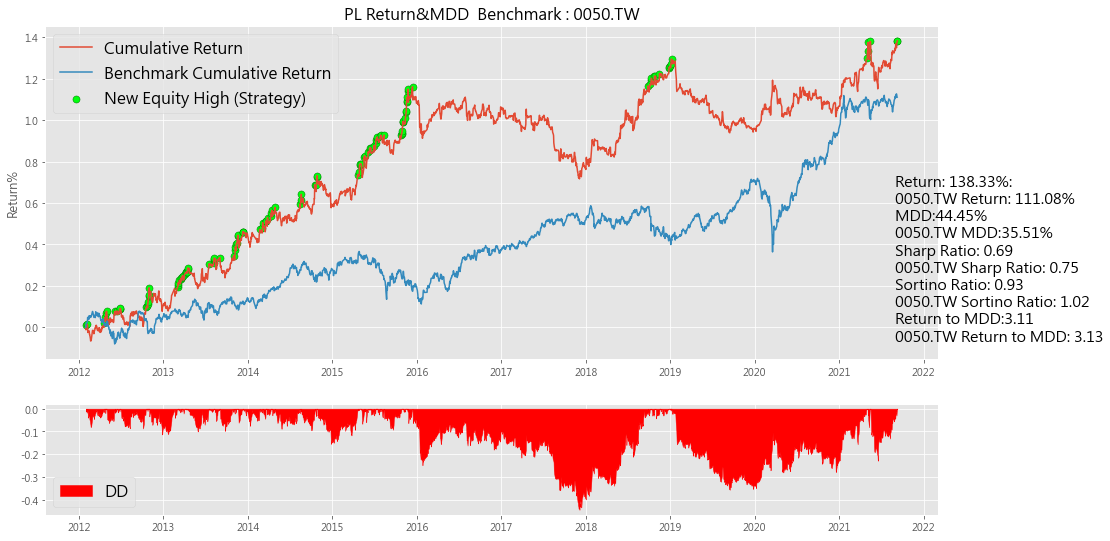

產業別 :  半導體    


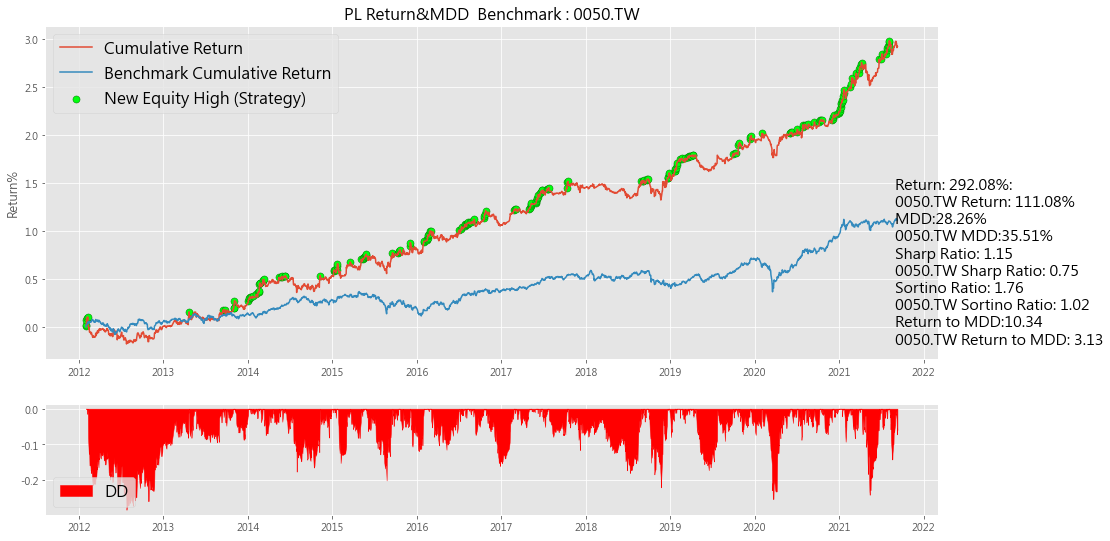

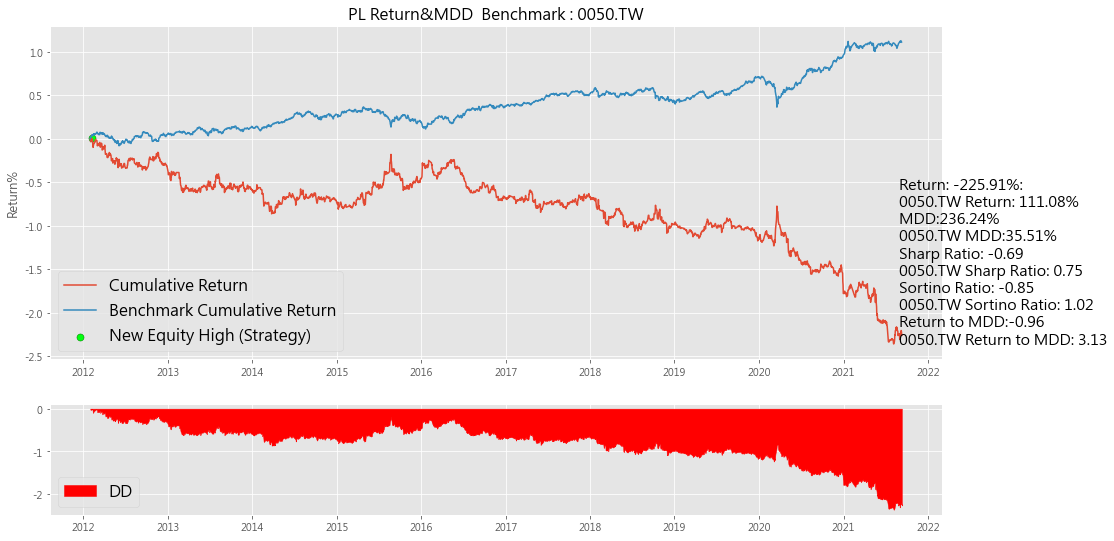

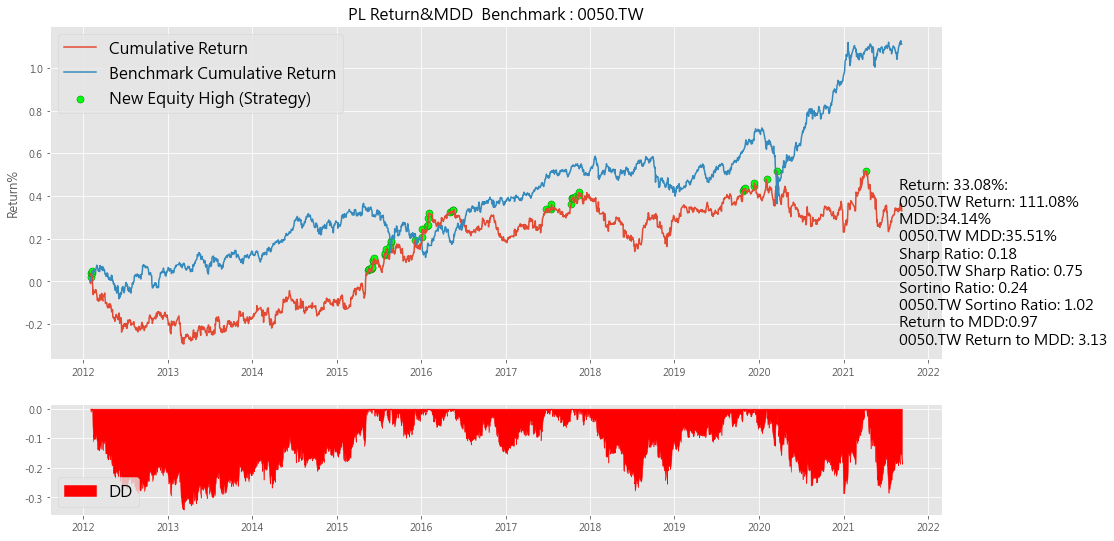

產業別 :  其他電子業


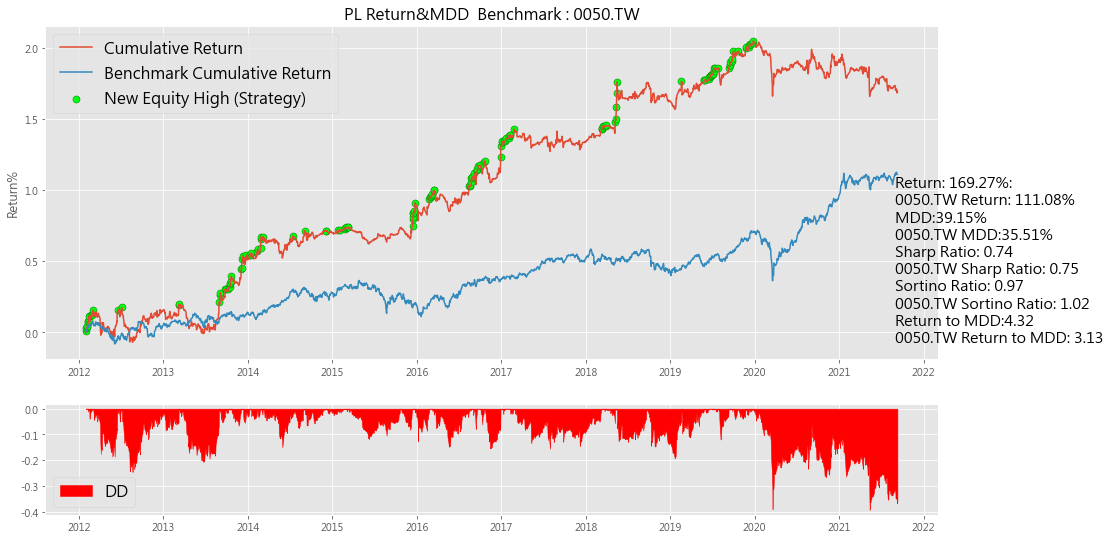

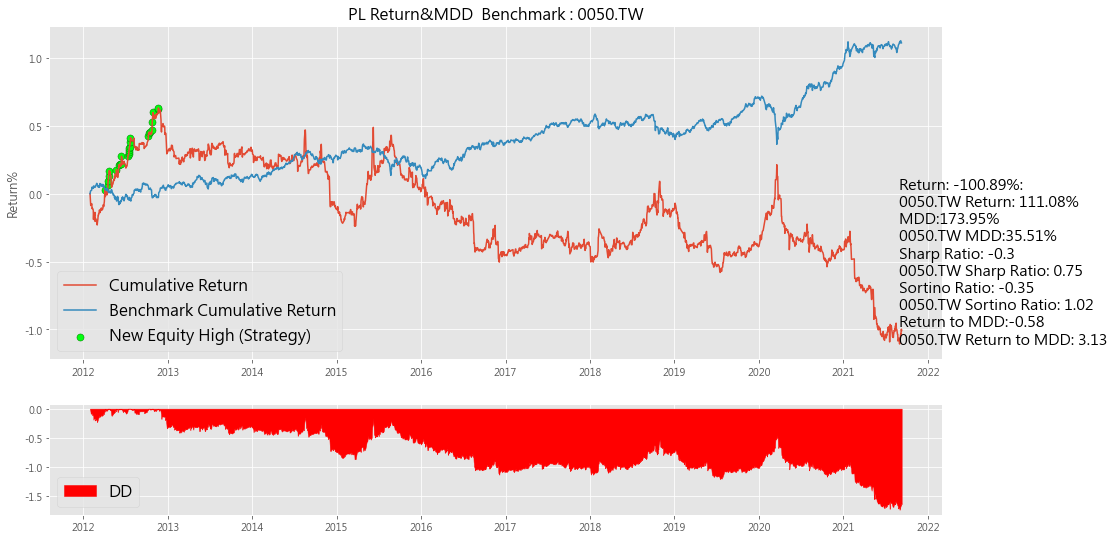

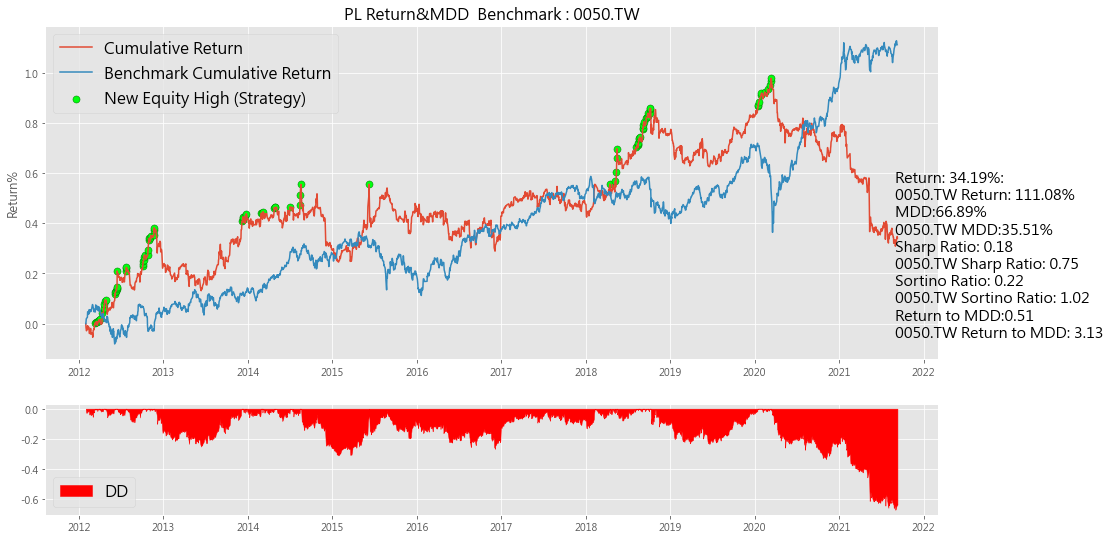

產業別 :  通信網路業


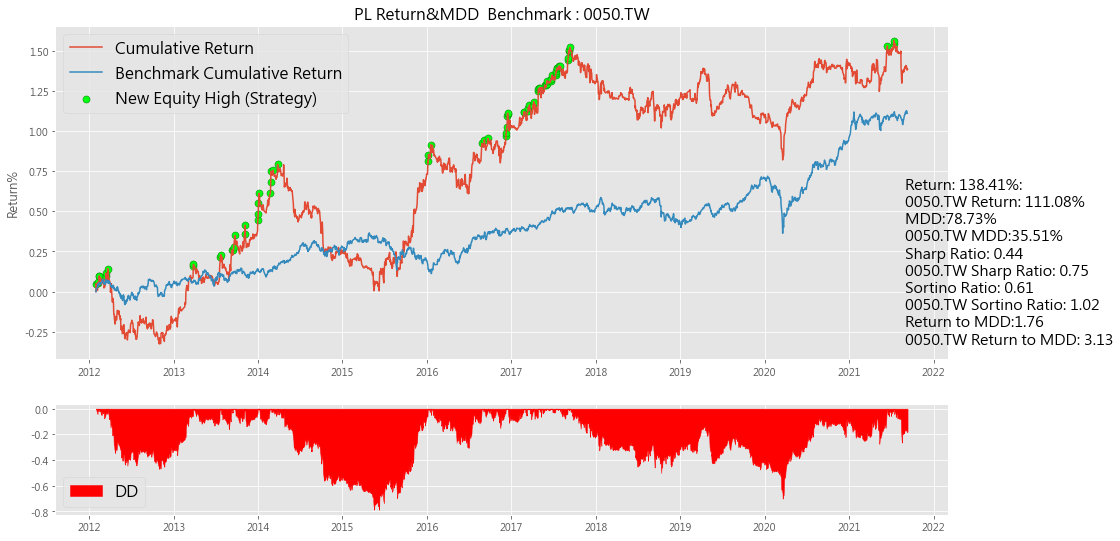

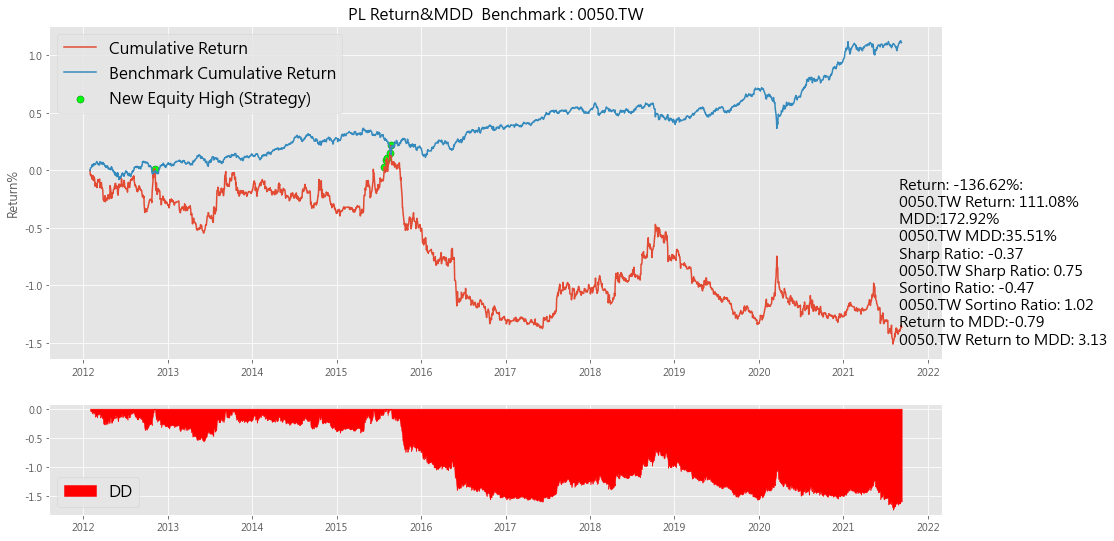

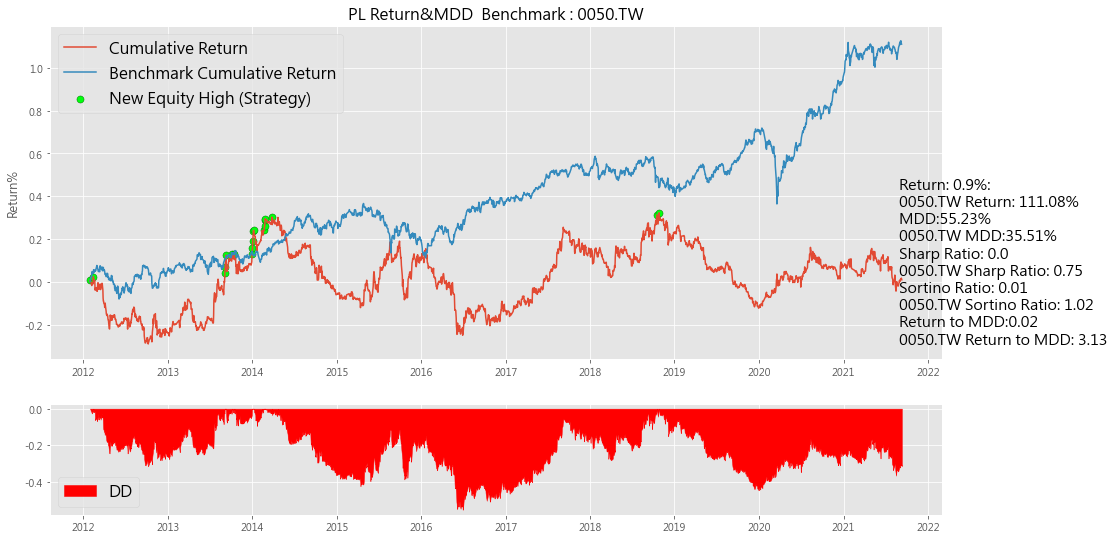

產業別 :  光電業    


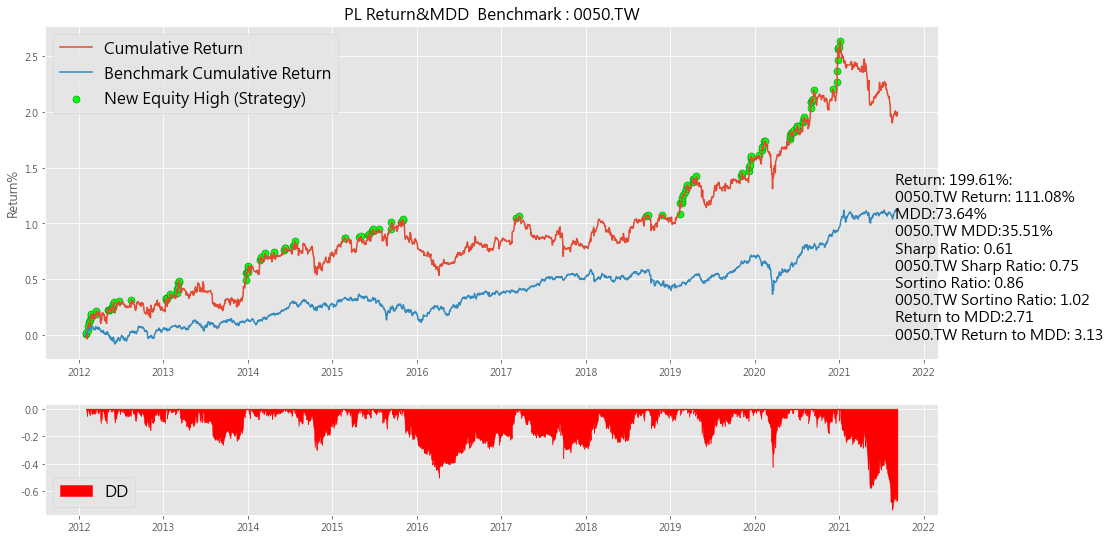

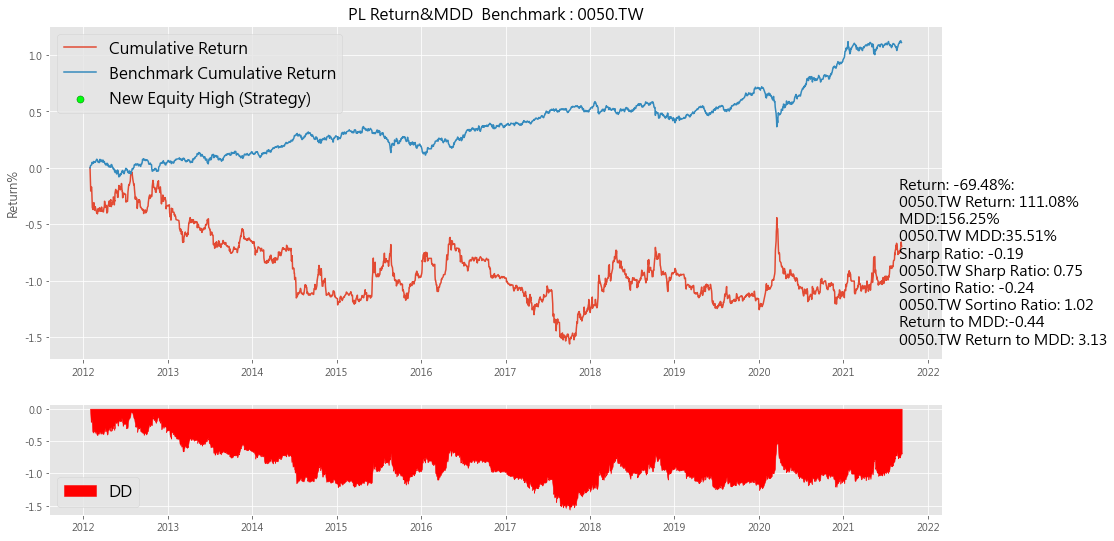

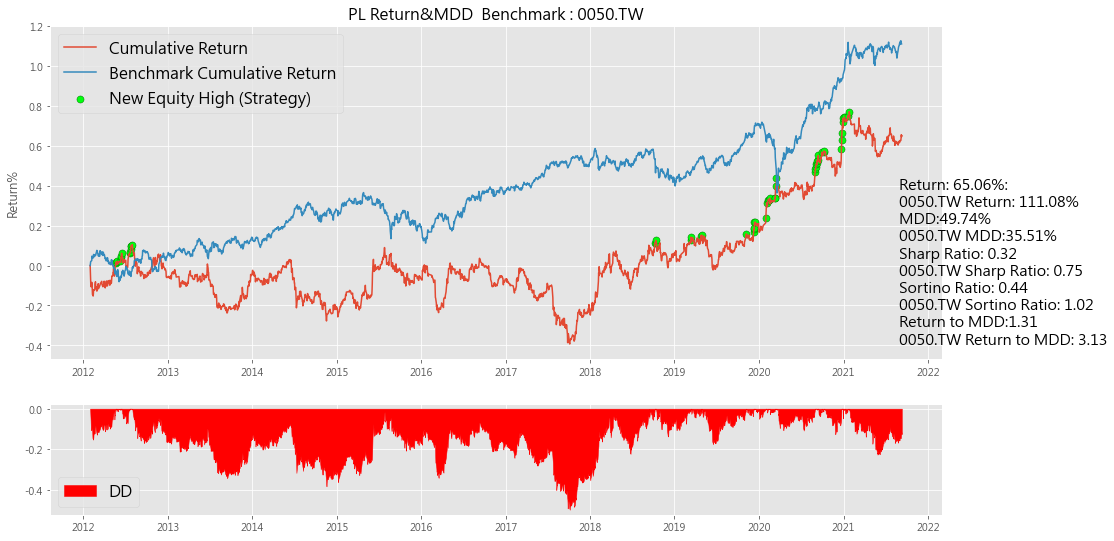

此次回測花費 79.07892155647278 秒


In [126]:
industry_ret_list = {}
industry_short_icir = {}
industry_long_icir = {}
start_time = time.time()
for industry in industry_list :  
    
    industry_set = set(stock_set) & set(industry_df[industry_df['TSE新產業_名稱'] == industry].公司簡稱.values)
    
    ret_long_list = []
    ret_short_list = []
    tic_long_list = []
    tic_short_list = []
    ret_port_list = []
    long_ic_list = []
    short_ic_list = []

    long_cut_1 = 5
    short_cut_1 = 1
    long_cut_2 = 1
    short_cut_2 = 5

    data1 = lend_df[industry_set]
    data2 = ret_pct_df     
#     long_cut = 5
#     short_cut = 1
    cut_size = 5
    cost = -0.001425

    data1 = signal_df[industry_set]
    # data1 = lend_df
    # data2 = stock_df
    # data3 = stock_21day_high

    
    for i in range(1,len(rebalance_list['start'])) :
        
        if (data1.loc[rebalance_list['end'][i-1]] != 0).sum() < cut_size :
            next
        
        else :
            
        #     訊號
#             long_signal = stock_signal(rebalance_list['end'][i-1],cut_size,long_cut,data1)

#             short_signal = stock_signal(rebalance_list['end'][i-1],cut_size,short_cut,data1)
            
            long_signal = stock_multi_signal(rebalance_list['end'][i-1],cut_size,long_cut_1,long_cut_2,data1,data2)

            short_signal = stock_multi_signal(rebalance_list['end'][i-1],cut_size,short_cut_1,short_cut_2,data1,data2)

            if long_signal.values.squeeze() != [] :
            #     回測
                ret_long_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_short_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

                tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

                ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

                tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns

                ret_long[0] = cost
                ret_short[0] = cost
                
            else :
                ret_long_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_short_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

                ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

                tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

                ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

                tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns

                
            ret_long_list.append(ret_long)
            tic_long_list.append(tic_long)

            ret_short_list.append(ret_short)
            tic_short_list.append(tic_short)

            ret_port_list.append((ret_long+ret_short)/2)
    
    ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
    tic_long_df = pd.DataFrame(tic_long_list)
    ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
    tic_short_df = pd.DataFrame(tic_short_list)
    ret_port_df = (ret_long_df+ret_short_df)/2
    
    sharpe = round(ret_long_df.mean()/ret_long_df.std()*(252**(1/2)),2)
    mdd = (ret_long_df.cumsum().cummax()-ret_long_df.cumsum()).max()
    ret_mdd =round((ret_long_df.cumsum().iloc[-1])/mdd,2)
    
    industry_ret_list[industry] = [str(round(ret_long_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_short_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                   str(round(ret_port_df.cumsum().iloc[-1].squeeze(),4)*100) + '%',
                                  sharpe.squeeze(),
                                  str(round(mdd.squeeze(),4)*100) + '%',
                                  ret_mdd.squeeze()]
    
    print("產業別 : ", industry)
    
    for i in [ret_long_df,ret_short_df,ret_port_df] :
        equity_plot(i.cumsum(),'0050.TW','PL',1)

end_time = time.time()
print('此次回測花費 %s 秒' %(end_time-start_time))

In [127]:
industy_ret_df = pd.DataFrame(industry_ret_list, index = ['做多','做空(不考慮融券費用&數量)','對沖','Sharpe','MDD','Return To MDD(做多)']).T
industy_ret_df.sort_values(['Return To MDD(做多)'],ascending = False)

做多        做空(不考慮融券費用&數量)                   對沖  \
電腦及週邊                 307.39%  -30.740000000000002%  138.32999999999998%   
半導體                   292.08%  -225.91000000000003%               33.08%   
其他電子業                 169.27%  -100.88999999999999%               34.19%   
其他                    158.83%               -39.87%               59.48%   
電機機械      118.91000000000001%               -76.32%               21.29%   
光電業       199.60999999999999%               -69.48%               65.06%   
建材營造      124.32000000000001%   -79.75999999999999%               22.28%   
電子零組件                 179.88%  -110.57999999999998%               34.65%   
生技醫療                    95.6%                -87.1%                4.25%   
通信網路業     138.41000000000003%              -136.62%  0.8999999999999999%   

         Sharpe                  MDD Return To MDD(做多)  
電腦及週邊      1.16  28.360000000000003%             10.84  
半導體        1.15               28.26%             10.34  
其他電子業      0.74               39.15%              4.32  
其他         0.77  38.550000000000004%              4.12  
電機機械       0.54               42.49%               2.8  
光電業        0.61               73.64%              2.71  
建材營造       0.67               46.35%              2.68  
電子零組件      0.79   67.82000000000001%              2.65  
生技醫療       0.41               47.78%               2.0  
通信網路業      0.44               78.73%              1.76